In [1]:
import numpy as np
import pandas as pd

#from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import numpy as np
import imageio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2

In [3]:
# Set GPU memory growth so that I can still work on my PC with other GPU hungry apps..
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

if gpu_devices:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)

# To use bloody mixed precision on my GPUs
#tf.keras.mixed_precision.set_global_policy('mixed_float16')

## Resources

Vanilla conditonal GAN: https://keras.io/examples/generative/conditional_gan/
Wasserstein GAN: https://keras.io/examples/generative/wgan_gp/

## Loading data

In [4]:
# Load the data my man
airfoils_opt_995 = np.load('./data/airfoils_opt_995.npy')
aoas_opt_995     = np.load('./data/aoas_opt_995.npy')
inp_paras_995    = np.load('./data/inp_paras_995.npy')

In [5]:
# 995 airfoils, 192 points, 2 for x and y
airfoils_opt_995.shape

(995, 192, 2)

In [6]:
# optimal angle of attack
aoas_opt_995.shape

(995,)

In [7]:
# Ma, Re, Lift
inp_paras_995.shape

(995, 3)

## Defining the inputs X and outputs Y of the GAN

In [8]:
X = inp_paras_995
Y = airfoils_opt_995

# Reshaping Y to get a 2D array
nsamples, nx, ny = Y.shape
Y = Y.reshape((nsamples,nx*ny))
Y.shape

(995, 384)

## Split in training, validation and test sets

In [9]:
scaler_x = StandardScaler() #GaussRankScaler() #QuantileTransformer(output_distribution='normal') #PowerTransformer() #MinMaxScaler(feature_range=(-1, 1)) # StandardScaler()
scaler_y = StandardScaler() #GaussRankScaler() #QuantileTransformer(output_distribution='normal') #PowerTransformer() #MinMaxScaler(feature_range=(-1, 1)) # StandardScaler() #MinMaxScaler()

# Split randomly the data into test and validation sets to avoid overfitting during training.
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.20, random_state=1)
X_valid, X_test, Y_valid, Y_test   = train_test_split(X_valid, Y_valid, test_size=0.5, random_state=1)

# Fit the scalers on the training data only!
scaler_x.fit(X_train)
scaler_y.fit(Y_train)

# Standardize the sets
x_train = scaler_x.transform(X_train).astype(np.float32)
x_valid = scaler_x.transform(X_valid).astype(np.float32)
x_test  = scaler_x.transform(X_test).astype(np.float32)

y_train = scaler_y.transform(Y_train).astype(np.float32)
y_valid = scaler_y.transform(Y_valid).astype(np.float32)
y_test  = scaler_y.transform(Y_test).astype(np.float32)

## Constants and hyperparameters

In [10]:
batch_size = 32
BATCH_SIZE = batch_size
num_channels = Y.shape[1] #1
num_classes = X.shape[1] # number op #10
#image_size = 28
#latent_dim = X.shape[1] #128
#n_neurons = 30
noise_dim = 100
latent_dim = noise_dim #indeed latent dim is the noise_dim. num_calsses is the size of the condition


In [23]:
Y.shape[1]

384

## Loading the dataset and preprocessing it

In [11]:
# labels -> op
# digits -> airfoils
all_op = np.concatenate([x_train, x_valid])
all_airfoils = np.concatenate([y_train, y_valid])
#nx, ny = all_airfoils.shape
#all_airfoils = np.reshape(all_airfoils,(nx,ny,1))

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_airfoils, all_op))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training airfoils: {all_airfoils.shape}")
print(f"Shape of training op: {all_op.shape}")

Shape of training airfoils: (895, 384)
Shape of training op: (895, 3)


## Calculating the number of input channel for the generator and discriminator

In [12]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes # and here the classes are used as they should
print(generator_in_channels, discriminator_in_channels)

103 387


## Selecting neural networks hyperparameters

In [13]:
activation = 'relu'
k_ini       = 'he_uniform'
L2_pen     = 1e-8
nb_neurons = 100
nb_layers  = 3
optimizer='Adam'

## Creating the discriminator and generator for the conditional GAN

In [14]:
# Create the discriminator.
# cGAN
# input layer
model_ANN = Sequential()
model_ANN.add(Dense(nb_neurons, input_dim=(discriminator_in_channels), activation=activation, kernel_initializer=k_ini,dtype=tf.float32))

# hidden layers
for i in range(nb_layers):
    if i == 0:
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(input_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
    elif i == (nb_layers-1): # Last layer
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(dense_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
    else:
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(dense_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
# output layer
model_ANN.add(Dense(1, activation='softmax',dtype=tf.float32))

discriminator = model_ANN

# Create the generator.
# cGAN
model_ANN = Sequential()

# input layer
model_ANN.add(Dense(nb_neurons, input_dim=(generator_in_channels), activation=activation, kernel_initializer=k_ini,dtype=tf.float32))

# hidden layers
for i in range(nb_layers):
    if i == 0:
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(input_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
    elif i == (nb_layers-1): # Last layer
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(dense_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
    else:
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(dense_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
# output layer
model_ANN.add(Dense(num_channels, dtype=tf.float32))



generator = model_ANN

## Creating the discriminator and generator for the Wasserstein conditional GAN

In [15]:
# WGAN
model_ANN = Sequential()

# input layer
model_ANN.add(Dense(nb_neurons, input_dim=(discriminator_in_channels), activation=activation, kernel_initializer=k_ini,dtype=tf.float32))

# hidden layers
for i in range(nb_layers):
    if i == 0:
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(input_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
    elif i == (nb_layers-1): # Last layer
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(dense_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
    else:
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(dense_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
# output layer
model_ANN.add(Dense(1, dtype=tf.float32))

d_model = model_ANN

# WGAN

model_ANN = Sequential()

# input layer
model_ANN.add(Dense(nb_neurons, input_dim=(generator_in_channels), activation=activation, kernel_initializer=k_ini,dtype=tf.float32))

# hidden layers
for i in range(nb_layers):
    if i == 0:
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(input_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
    elif i == (nb_layers-1): # Last layer
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(dense_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
    else:
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(dense_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
# output layer
model_ANN.add(Dense(num_channels, dtype=tf.float32))

g_model = model_ANN

## Creating a vanilla conditional GAN (cGAN) model

In [20]:
from tensorflow import keras
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    # all good till here
    def train_step(self, data):
        # Unpack the data.
        # real_images -> real_airfoils
        # one_hot_labels -> op
        real_airfoils, op = data

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_airfoils)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim), dtype=tf.float32)
        random_vector_labels = tf.concat(
            [random_latent_vectors, op], axis=1
        )
        print('random_vector_labels shape', random_vector_labels.shape)
        # all good till here
        
        # Decode the noise (guided by labels) to fake airfoils.
        generated_airfoils = self.generator(random_vector_labels)
        print('generated_airfoils shape', generated_airfoils.shape)

        # Combine them with real airfoils. 
        fake_airfoils = tf.concat([generated_airfoils,op],axis=1)
        print('fake_airfoils shape', fake_airfoils.shape)
        real_airfoils = tf.concat([real_airfoils,op],axis=1)
        print('real_airfoils shape', real_airfoils.shape)
        combined_airfoils = tf.concat(
            [fake_airfoils, real_airfoils], axis=0
        )
        print('combined_airfoils shape', combined_airfoils.shape)

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1), dtype=tf.float32), tf.zeros((batch_size, 1), dtype=tf.float32)], axis=0
        )
        print('tf.ones((batch_size, 1)', tf.ones((batch_size, 1)))
        print('labels shape', labels.shape)

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_airfoils)
            print('predictions shape', predictions.shape)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim), dtype=tf.float32)
        print('random_latent_vectors shape', random_latent_vectors.shape)
        random_vector_labels = tf.concat(
            [random_latent_vectors, op], axis=1
        )
        print('random_vector_labels shape', random_vector_labels.shape)

        # Assemble labels that say "all real airfoils".
        misleading_labels = tf.zeros((batch_size, 1))
        print('misleading_labels shape', misleading_labels.shape)

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_airfoils = self.generator(random_vector_labels)
            print('fake_airfoils shape', fake_airfoils.shape)
            fake_airfoils = tf.concat([fake_airfoils, op], axis=1)
            predictions = self.discriminator(fake_airfoils)
            print('predictions shape', predictions.shape)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


## Creating a Wasserstein conditional GAN (WcGAN) model

In [24]:
from tensorflow import keras
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_airfoils, fake_airfoils):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated airfoil
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, tf.shape(real_airfoils)[1]], 0.0, 1.0)
        diff = fake_airfoils - real_airfoils
        interpolated = real_airfoils + alpha * diff

        # good till here
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        
        real_airfoils, op = data
        
        if isinstance(real_airfoils, tuple):
            real_airfoils = real_airfoils[0]
            
        real_airfoils = tf.concat([real_airfoils,op],axis=1)
        # Get the batch size
        batch_size = tf.shape(real_airfoils)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim), dtype=tf.float32)
            random_vector_labels = tf.concat(
                [random_latent_vectors, op], axis=1
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_airfoils = self.generator(random_vector_labels, training=True)
                fake_airfoils = tf.concat([fake_airfoils,op],axis=1)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_airfoils, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_airfoils, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_afl=real_logits, fake_afl=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_airfoils, fake_airfoils)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )
        #good till here
        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim), dtype=tf.float32)
        random_vector_labels = tf.concat([random_latent_vectors, op], axis=1)
        
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_airfoils = self.generator(random_vector_labels, training=True)
            generated_airfoils = tf.concat([generated_airfoils,op],axis=1)
            # Get the discriminator logits for fake images
            gen_afl_logits = self.discriminator(generated_airfoils, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_afl_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}


## Training the Wasserstein conditional GAN

In [25]:
#Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0003, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0003, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_afl, fake_afl):
    real_loss = tf.reduce_mean(real_afl)
    fake_loss = tf.reduce_mean(fake_afl)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_afl):
    return -tf.reduce_mean(fake_afl)


# Set the number of epochs for training.
epochs = 500


# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training
wgan.fit(dataset, batch_size=BATCH_SIZE, epochs=epochs)

Epoch 1/500
28/28 [==============================] - 4s 37ms/step - d_loss: -9.0266 - g_loss: 0.4647
Epoch 2/500
28/28 [==============================] - 1s 34ms/step - d_loss: -18.4943 - g_loss: -0.6465
Epoch 3/500
28/28 [==============================] - 1s 35ms/step - d_loss: -20.1314 - g_loss: -0.0323
Epoch 4/500
28/28 [==============================] - 1s 33ms/step - d_loss: -21.6229 - g_loss: 0.8248
Epoch 5/500
28/28 [==============================] - 1s 30ms/step - d_loss: -22.2519 - g_loss: 0.8694
Epoch 6/500
28/28 [==============================] - 1s 31ms/step - d_loss: -22.0138 - g_loss: -0.1283
Epoch 7/500
28/28 [==============================] - 1s 31ms/step - d_loss: -20.5624 - g_loss: -0.7035
Epoch 8/500
28/28 [==============================] - 1s 31ms/step - d_loss: -19.9055 - g_loss: 0.9329
Epoch 9/500
28/28 [==============================] - 1s 30ms/step - d_loss: -19.8395 - g_loss: 2.7736
Epoch 10/500
28/28 [==============================] - 1s 31ms/step - d_loss: -2

28/28 [==============================] - 1s 34ms/step - d_loss: -8.5526 - g_loss: 13.4909
Epoch 81/500
28/28 [==============================] - 1s 32ms/step - d_loss: -8.3165 - g_loss: 13.6590
Epoch 82/500
28/28 [==============================] - 1s 23ms/step - d_loss: -8.2650 - g_loss: 12.7947
Epoch 83/500
28/28 [==============================] - 1s 24ms/step - d_loss: -8.6111 - g_loss: 14.9352
Epoch 84/500
28/28 [==============================] - 1s 23ms/step - d_loss: -8.1255 - g_loss: 13.8865
Epoch 85/500
28/28 [==============================] - 1s 27ms/step - d_loss: -8.2878 - g_loss: 14.6013
Epoch 86/500
28/28 [==============================] - 1s 29ms/step - d_loss: -8.7336 - g_loss: 16.2686
Epoch 87/500
28/28 [==============================] - 1s 28ms/step - d_loss: -8.2482 - g_loss: 15.7044
Epoch 88/500
28/28 [==============================] - 1s 29ms/step - d_loss: -8.1996 - g_loss: 14.0670
Epoch 89/500
28/28 [==============================] - 1s 32ms/step - d_loss: -8.3295 -

28/28 [==============================] - 1s 29ms/step - d_loss: -5.2556 - g_loss: 21.6929
Epoch 160/500
28/28 [==============================] - 1s 30ms/step - d_loss: -5.1317 - g_loss: 20.6911
Epoch 161/500
28/28 [==============================] - 1s 30ms/step - d_loss: -5.0400 - g_loss: 20.7055
Epoch 162/500
28/28 [==============================] - 1s 30ms/step - d_loss: -5.2053 - g_loss: 21.1055
Epoch 163/500
28/28 [==============================] - 1s 30ms/step - d_loss: -5.2737 - g_loss: 21.3283
Epoch 164/500
28/28 [==============================] - 1s 30ms/step - d_loss: -5.5562 - g_loss: 20.7659
Epoch 165/500
28/28 [==============================] - 1s 30ms/step - d_loss: -5.4480 - g_loss: 20.6770
Epoch 166/500
28/28 [==============================] - 1s 30ms/step - d_loss: -5.3249 - g_loss: 20.5539
Epoch 167/500
28/28 [==============================] - 1s 31ms/step - d_loss: -5.4683 - g_loss: 19.2996
Epoch 168/500
28/28 [==============================] - 1s 30ms/step - d_loss: 

28/28 [==============================] - 1s 28ms/step - d_loss: -3.5741 - g_loss: 15.0955
Epoch 238/500
28/28 [==============================] - 1s 27ms/step - d_loss: -3.6511 - g_loss: 15.1540
Epoch 239/500
28/28 [==============================] - 1s 29ms/step - d_loss: -3.7628 - g_loss: 17.7852
Epoch 240/500
28/28 [==============================] - 1s 31ms/step - d_loss: -4.1333 - g_loss: 17.9130
Epoch 241/500
28/28 [==============================] - 1s 30ms/step - d_loss: -4.5148 - g_loss: 17.6220
Epoch 242/500
28/28 [==============================] - 1s 30ms/step - d_loss: -3.6487 - g_loss: 17.4106
Epoch 243/500
28/28 [==============================] - 1s 30ms/step - d_loss: -4.4256 - g_loss: 16.0552
Epoch 244/500
28/28 [==============================] - 1s 30ms/step - d_loss: -3.6697 - g_loss: 16.0780
Epoch 245/500
28/28 [==============================] - 1s 31ms/step - d_loss: -3.9632 - g_loss: 15.4892
Epoch 246/500
28/28 [==============================] - 1s 29ms/step - d_loss: 

28/28 [==============================] - 1s 28ms/step - d_loss: -3.5435 - g_loss: 13.4764
Epoch 316/500
28/28 [==============================] - 1s 30ms/step - d_loss: -2.7005 - g_loss: 11.8733
Epoch 317/500
28/28 [==============================] - 1s 28ms/step - d_loss: -2.6876 - g_loss: 11.2097
Epoch 318/500
28/28 [==============================] - 1s 28ms/step - d_loss: -2.9495 - g_loss: 11.1072
Epoch 319/500
28/28 [==============================] - 1s 33ms/step - d_loss: -3.1652 - g_loss: 11.8149
Epoch 320/500
28/28 [==============================] - 1s 31ms/step - d_loss: -2.9053 - g_loss: 11.4659
Epoch 321/500
28/28 [==============================] - 1s 30ms/step - d_loss: -3.6591 - g_loss: 12.0525
Epoch 322/500
28/28 [==============================] - 1s 29ms/step - d_loss: -2.9461 - g_loss: 10.8370
Epoch 323/500
28/28 [==============================] - 1s 28ms/step - d_loss: -3.0973 - g_loss: 13.7737
Epoch 324/500
28/28 [==============================] - 1s 27ms/step - d_loss: 

Epoch 394/500
28/28 [==============================] - 1s 23ms/step - d_loss: -2.3290 - g_loss: 12.0232
Epoch 395/500
28/28 [==============================] - 1s 28ms/step - d_loss: -2.9860 - g_loss: 12.3294
Epoch 396/500
28/28 [==============================] - 1s 28ms/step - d_loss: -2.9445 - g_loss: 13.3062
Epoch 397/500
28/28 [==============================] - 1s 28ms/step - d_loss: -3.1999 - g_loss: 13.3133
Epoch 398/500
28/28 [==============================] - 1s 29ms/step - d_loss: -2.8259 - g_loss: 11.8974
Epoch 399/500
28/28 [==============================] - 1s 29ms/step - d_loss: -2.6620 - g_loss: 11.1582
Epoch 400/500
28/28 [==============================] - 1s 30ms/step - d_loss: -2.6221 - g_loss: 11.2084
Epoch 401/500
28/28 [==============================] - 1s 30ms/step - d_loss: -2.5991 - g_loss: 10.8036
Epoch 402/500
28/28 [==============================] - 1s 30ms/step - d_loss: -3.0380 - g_loss: 12.5621
Epoch 403/500
28/28 [==============================] - 1s 31ms/s

28/28 [==============================] - 1s 29ms/step - d_loss: -2.4727 - g_loss: 12.7003
Epoch 473/500
28/28 [==============================] - 1s 30ms/step - d_loss: -2.3207 - g_loss: 10.5663
Epoch 474/500
28/28 [==============================] - 1s 30ms/step - d_loss: -2.8862 - g_loss: 11.8073
Epoch 475/500
28/28 [==============================] - 1s 31ms/step - d_loss: -2.4966 - g_loss: 10.1430
Epoch 476/500
28/28 [==============================] - 1s 30ms/step - d_loss: -3.0279 - g_loss: 10.5750
Epoch 477/500
28/28 [==============================] - 1s 30ms/step - d_loss: -2.5228 - g_loss: 8.7530
Epoch 478/500
28/28 [==============================] - 1s 30ms/step - d_loss: -2.5211 - g_loss: 8.9845
Epoch 479/500
28/28 [==============================] - 1s 33ms/step - d_loss: -2.4203 - g_loss: 10.3056
Epoch 480/500
28/28 [==============================] - 1s 29ms/step - d_loss: -2.2354 - g_loss: 9.5343
Epoch 481/500
28/28 [==============================] - 1s 28ms/step - d_loss: -2.

## Plot WcGAN losses

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


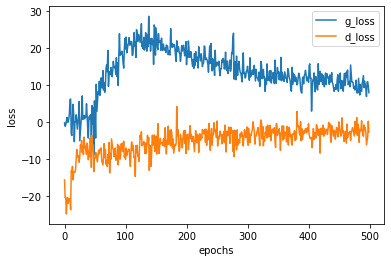

In [27]:
# record history
plt.plot([i for i in range(epochs)], wgan.history.history['g_loss'],label ='g_loss')
plt.plot([i for i in range(epochs)], wgan.history.history['d_loss'],label ='d_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend() 
plt.savefig('./losses/wcgan_loss.png')
plt.savefig('./losses/wcgan_loss.eps', format='eps')
plt.savefig('./losses/wcgan_loss.pdf', format='pdf')
plt.show()

## Training the vanilla conditional GAN

In [51]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=noise_dim
)
cond_gan.compile(d_optimizer=keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5, beta_2=0.9),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5, beta_2=0.9),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=False),
)

cond_gan.fit(dataset, epochs=epochs)

Epoch 1/500
random_vector_labels shape (None, 103)
generated_airfoils shape (None, 384)
fake_airfoils shape (None, 387)
real_airfoils shape (None, 387)
combined_airfoils shape (None, 387)
tf.ones((batch_size, 1) Tensor("ones_1:0", shape=(None, 1), dtype=float32)
labels shape (None, 1)
predictions shape (None, 1)
random_latent_vectors shape (None, 100)
random_vector_labels shape (None, 103)
misleading_labels shape (None, 1)
fake_airfoils shape (None, 384)
predictions shape (None, 1)
random_vector_labels shape (None, 103)
generated_airfoils shape (None, 384)
fake_airfoils shape (None, 387)
real_airfoils shape (None, 387)
combined_airfoils shape (None, 387)
tf.ones((batch_size, 1) Tensor("ones_1:0", shape=(None, 1), dtype=float32)
labels shape (None, 1)
predictions shape (None, 1)
random_latent_vectors shape (None, 100)
random_vector_labels shape (None, 103)
misleading_labels shape (None, 1)
fake_airfoils shape (None, 384)
predictions shape (None, 1)
28/28 [==============================]

28/28 [==============================] - 0s 10ms/step - g_loss: 4.0436 - d_loss: 0.1550
Epoch 73/500
28/28 [==============================] - 0s 10ms/step - g_loss: 4.0068 - d_loss: 0.1588
Epoch 74/500
28/28 [==============================] - 0s 11ms/step - g_loss: 3.8047 - d_loss: 0.1597
Epoch 75/500
28/28 [==============================] - 0s 11ms/step - g_loss: 3.9497 - d_loss: 0.1584
Epoch 76/500
28/28 [==============================] - 0s 11ms/step - g_loss: 4.2057 - d_loss: 0.1362
Epoch 77/500
28/28 [==============================] - 0s 11ms/step - g_loss: 3.7981 - d_loss: 0.1657
Epoch 78/500
28/28 [==============================] - 0s 12ms/step - g_loss: 4.1910 - d_loss: 0.1859
Epoch 79/500
28/28 [==============================] - 0s 11ms/step - g_loss: 3.7193 - d_loss: 0.1752
Epoch 80/500
28/28 [==============================] - 0s 11ms/step - g_loss: 3.6188 - d_loss: 0.1898
Epoch 81/500
28/28 [==============================] - 0s 11ms/step - g_loss: 3.9283 - d_loss: 0.1603
Epo

28/28 [==============================] - 0s 12ms/step - g_loss: 3.6380 - d_loss: 0.1657
Epoch 153/500
28/28 [==============================] - 0s 10ms/step - g_loss: 3.6287 - d_loss: 0.1721
Epoch 154/500
28/28 [==============================] - 0s 11ms/step - g_loss: 3.7464 - d_loss: 0.1463
Epoch 155/500
28/28 [==============================] - 0s 11ms/step - g_loss: 3.8767 - d_loss: 0.1568
Epoch 156/500
28/28 [==============================] - 0s 10ms/step - g_loss: 4.0569 - d_loss: 0.1302
Epoch 157/500
28/28 [==============================] - 0s 10ms/step - g_loss: 3.9703 - d_loss: 0.1499
Epoch 158/500
28/28 [==============================] - 0s 10ms/step - g_loss: 4.0007 - d_loss: 0.1327
Epoch 159/500
28/28 [==============================] - 0s 11ms/step - g_loss: 3.6726 - d_loss: 0.1534
Epoch 160/500
28/28 [==============================] - 0s 11ms/step - g_loss: 3.9211 - d_loss: 0.1352
Epoch 161/500
28/28 [==============================] - 0s 10ms/step - g_loss: 3.7455 - d_loss: 0

28/28 [==============================] - 0s 9ms/step - g_loss: 3.7467 - d_loss: 0.1616
Epoch 233/500
28/28 [==============================] - 0s 10ms/step - g_loss: 3.6580 - d_loss: 0.1786
Epoch 234/500
28/28 [==============================] - 0s 10ms/step - g_loss: 3.4667 - d_loss: 0.1701
Epoch 235/500
28/28 [==============================] - 0s 10ms/step - g_loss: 3.4337 - d_loss: 0.1583
Epoch 236/500
28/28 [==============================] - 0s 10ms/step - g_loss: 3.9027 - d_loss: 0.1326
Epoch 237/500
28/28 [==============================] - 0s 9ms/step - g_loss: 3.8435 - d_loss: 0.1852
Epoch 238/500
28/28 [==============================] - 0s 9ms/step - g_loss: 3.4462 - d_loss: 0.2154
Epoch 239/500
28/28 [==============================] - 0s 10ms/step - g_loss: 3.7801 - d_loss: 0.1761
Epoch 240/500
28/28 [==============================] - 0s 11ms/step - g_loss: 3.5737 - d_loss: 0.1873
Epoch 241/500
28/28 [==============================] - 0s 11ms/step - g_loss: 3.6925 - d_loss: 0.15

28/28 [==============================] - 0s 11ms/step - g_loss: 4.2195 - d_loss: 0.1391
Epoch 313/500
28/28 [==============================] - 0s 10ms/step - g_loss: 4.8017 - d_loss: 0.1520
Epoch 314/500
28/28 [==============================] - 0s 11ms/step - g_loss: 5.2175 - d_loss: 0.1895
Epoch 315/500
28/28 [==============================] - 0s 10ms/step - g_loss: 4.8150 - d_loss: 0.3257
Epoch 316/500
28/28 [==============================] - 0s 12ms/step - g_loss: 5.0056 - d_loss: 0.3840
Epoch 317/500
28/28 [==============================] - 0s 11ms/step - g_loss: 4.7220 - d_loss: 0.3944
Epoch 318/500
28/28 [==============================] - 0s 12ms/step - g_loss: 4.1101 - d_loss: 0.3258
Epoch 319/500
28/28 [==============================] - 0s 12ms/step - g_loss: 3.7361 - d_loss: 0.2330
Epoch 320/500
28/28 [==============================] - 0s 9ms/step - g_loss: 3.8948 - d_loss: 0.1856
Epoch 321/500
28/28 [==============================] - 0s 10ms/step - g_loss: 5.0679 - d_loss: 0.

28/28 [==============================] - 0s 11ms/step - g_loss: 3.9606 - d_loss: 0.1766
Epoch 393/500
28/28 [==============================] - 0s 11ms/step - g_loss: 4.0741 - d_loss: 0.1392
Epoch 394/500
28/28 [==============================] - 0s 13ms/step - g_loss: 4.2183 - d_loss: 0.1519
Epoch 395/500
28/28 [==============================] - 0s 13ms/step - g_loss: 4.8304 - d_loss: 0.1502
Epoch 396/500
28/28 [==============================] - 0s 11ms/step - g_loss: 4.5196 - d_loss: 0.2586
Epoch 397/500
28/28 [==============================] - 0s 11ms/step - g_loss: 7.7297 - d_loss: 0.3282
Epoch 398/500
28/28 [==============================] - 0s 10ms/step - g_loss: 6.2618 - d_loss: 0.2404
Epoch 399/500
28/28 [==============================] - 0s 10ms/step - g_loss: 5.2732 - d_loss: 0.2755
Epoch 400/500
28/28 [==============================] - 0s 11ms/step - g_loss: 5.0025 - d_loss: 0.2512
Epoch 401/500
28/28 [==============================] - 0s 11ms/step - g_loss: 5.1762 - d_loss: 0

28/28 [==============================] - 0s 10ms/step - g_loss: 4.2241 - d_loss: 0.1423
Epoch 473/500
28/28 [==============================] - 0s 10ms/step - g_loss: 4.2454 - d_loss: 0.1561
Epoch 474/500
28/28 [==============================] - 0s 11ms/step - g_loss: 4.2927 - d_loss: 0.1340
Epoch 475/500
28/28 [==============================] - 0s 11ms/step - g_loss: 4.4200 - d_loss: 0.1017
Epoch 476/500
28/28 [==============================] - 0s 10ms/step - g_loss: 4.4036 - d_loss: 0.1182
Epoch 477/500
28/28 [==============================] - 0s 11ms/step - g_loss: 4.4334 - d_loss: 0.1393
Epoch 478/500
28/28 [==============================] - 0s 11ms/step - g_loss: 4.7022 - d_loss: 0.1361
Epoch 479/500
28/28 [==============================] - 0s 12ms/step - g_loss: 4.4260 - d_loss: 0.1343
Epoch 480/500
28/28 [==============================] - 0s 13ms/step - g_loss: 4.4043 - d_loss: 0.1818
Epoch 481/500
28/28 [==============================] - 0s 11ms/step - g_loss: 4.3979 - d_loss: 0

## Plot vanilla cGan

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


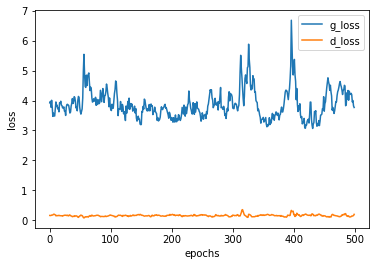

In [52]:
# record history
plt.plot([i for i in range(epochs)], cond_gan.history.history['g_loss'],label ='g_loss')
plt.plot([i for i in range(epochs)], cond_gan.history.history['d_loss'],label ='d_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend() 
plt.savefig('./losses/cgan_loss.png')
plt.savefig('./losses/cgan_loss.eps', format='eps')
plt.savefig('./losses/cgan_loss.pdf', format='pdf')
plt.show()

## Predict with the generator and Plot the airfoil for WcGAN

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


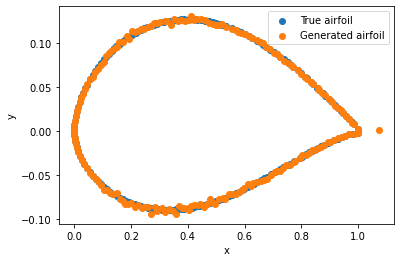

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


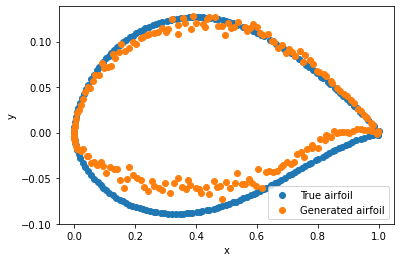

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


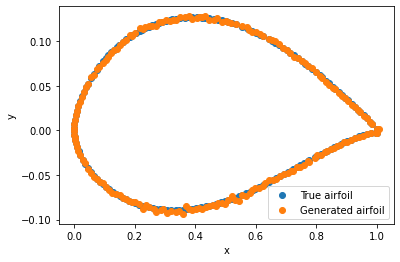

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


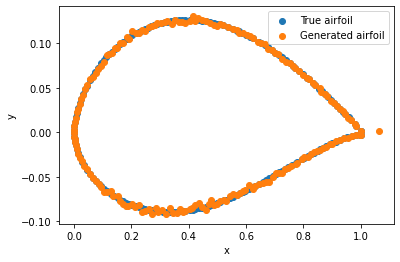

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


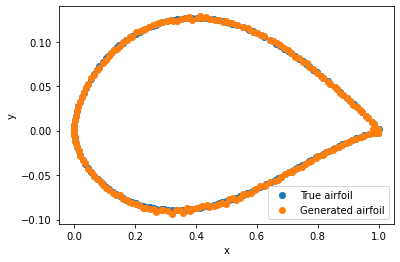

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


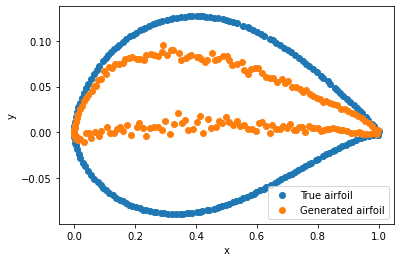

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


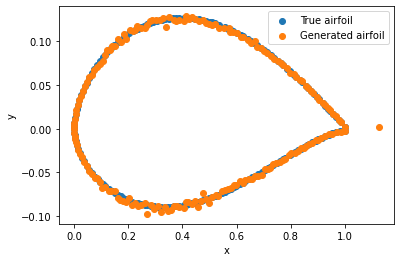

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


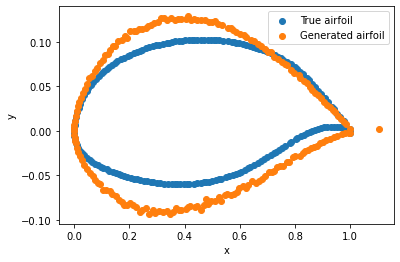

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


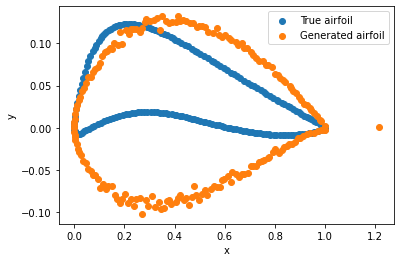

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


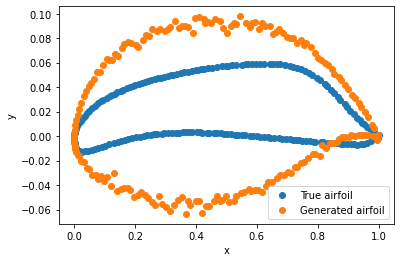

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


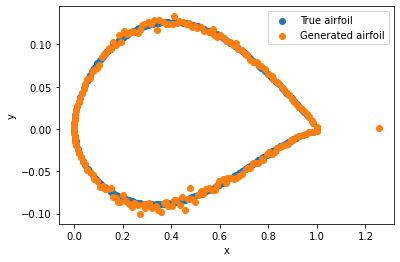

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


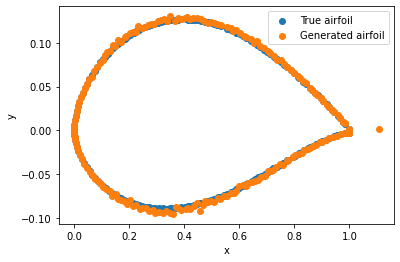

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


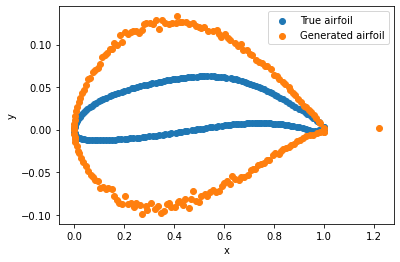

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


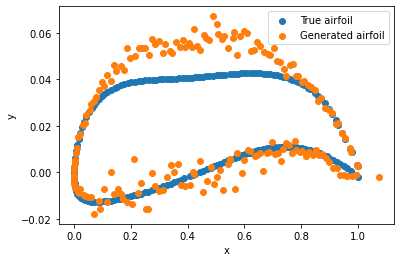

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


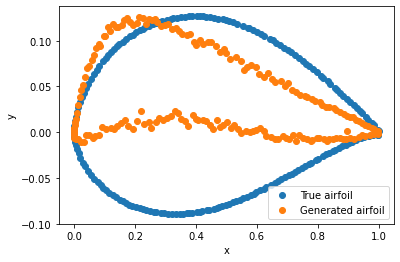

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


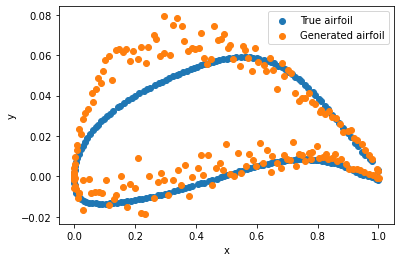

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


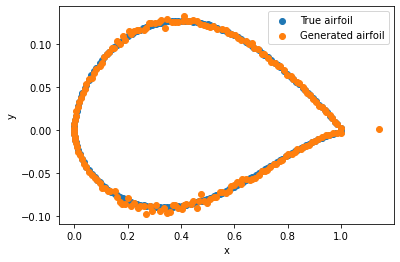

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


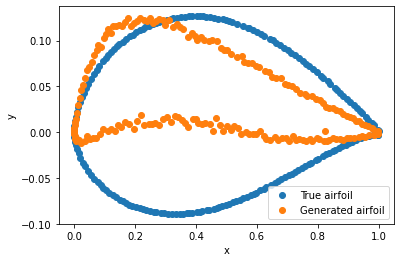

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


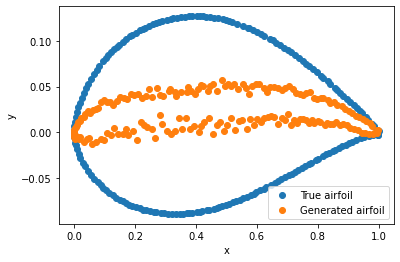

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


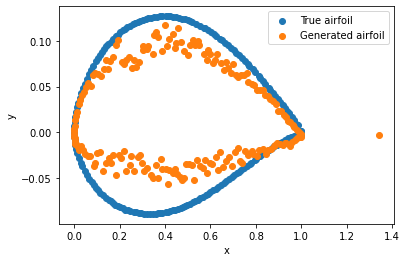

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


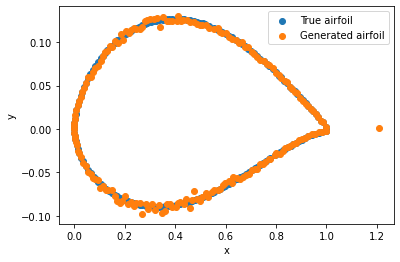

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


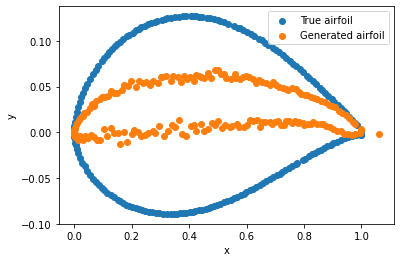

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


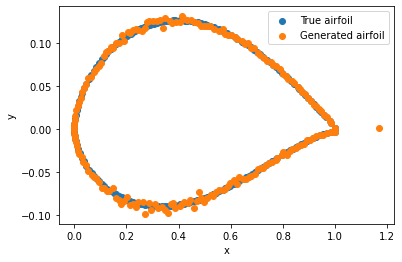

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


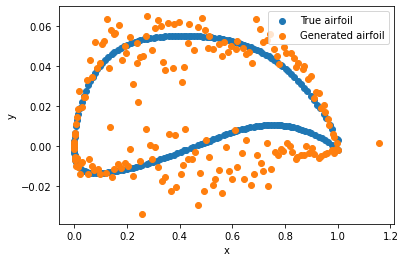

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


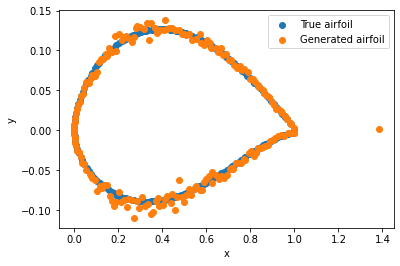

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


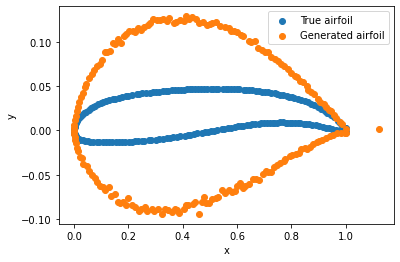

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


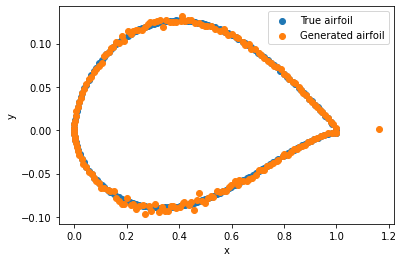

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


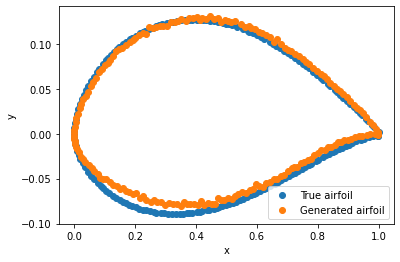

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


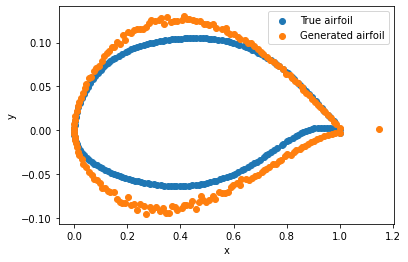

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


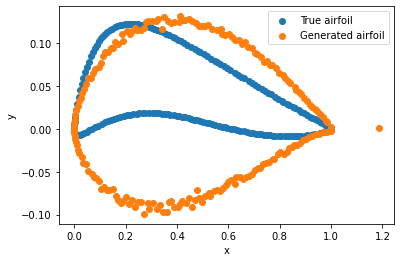

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


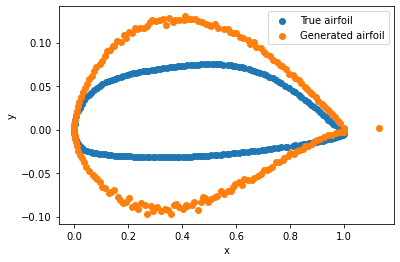

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


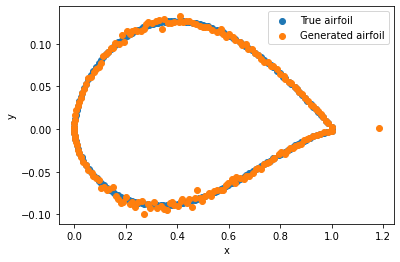

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


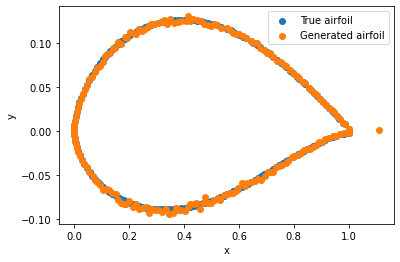

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


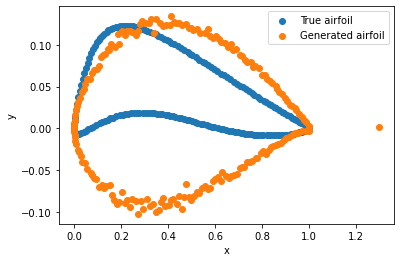

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


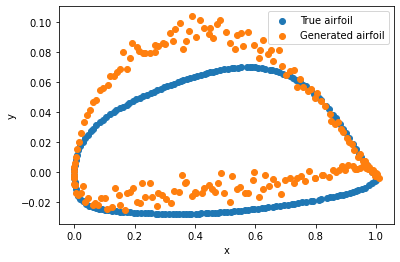

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


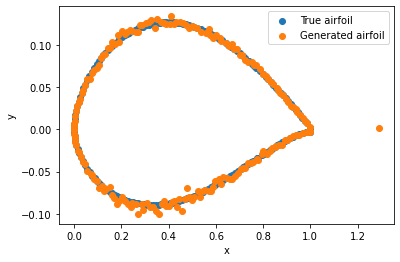

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


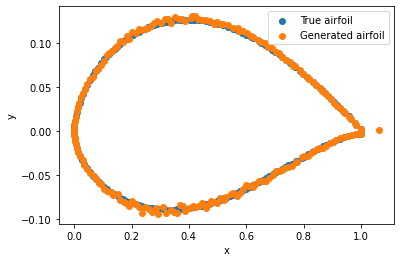

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


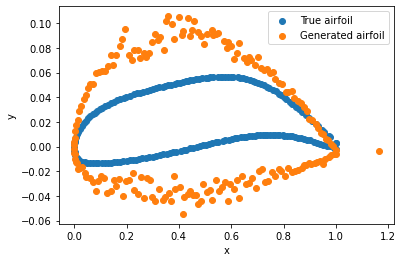

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


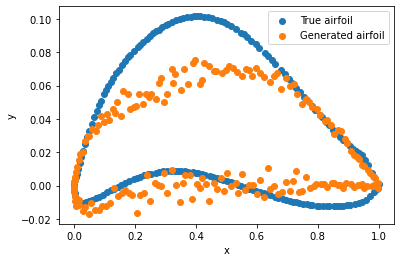

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


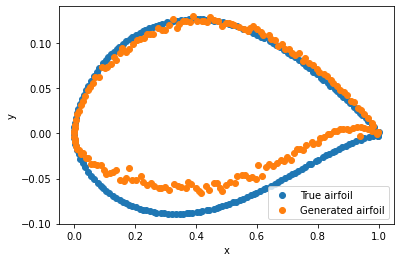

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


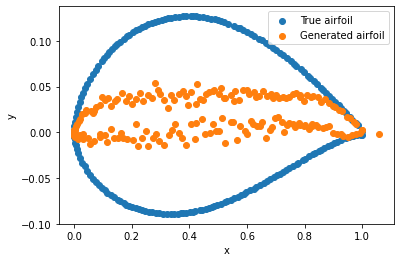

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


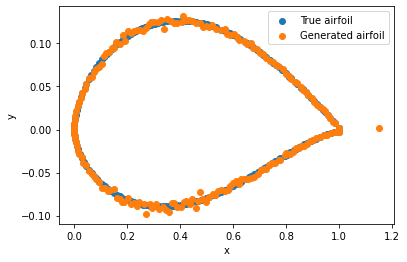

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


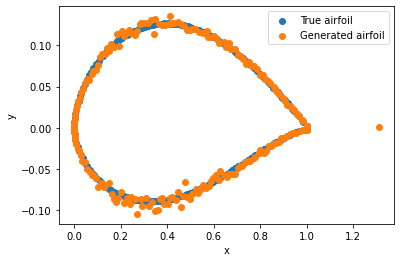

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


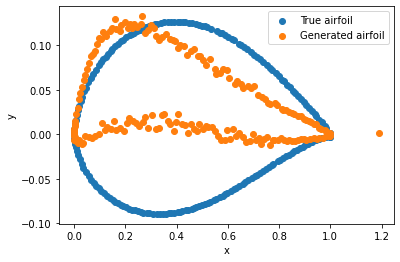

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


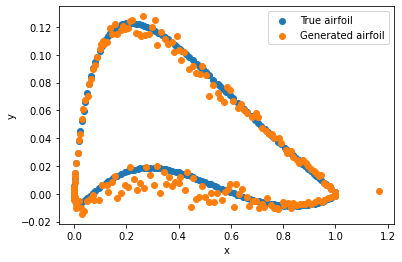

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


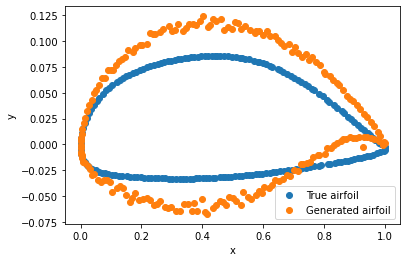

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


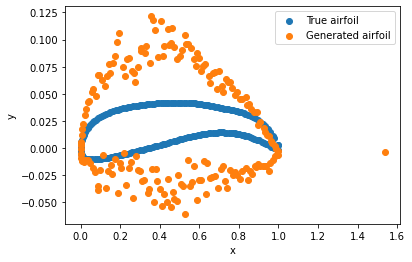

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


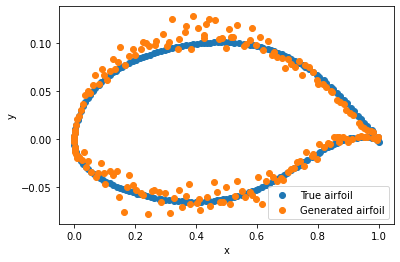

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


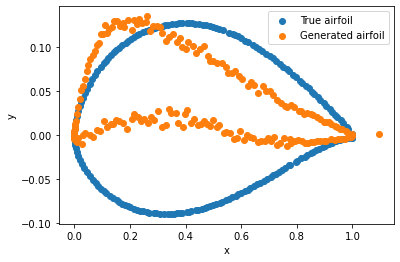

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


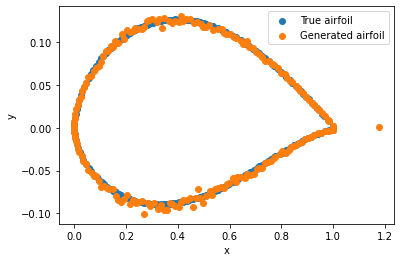

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


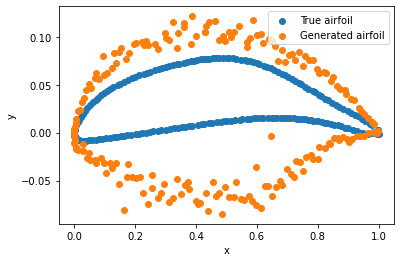

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


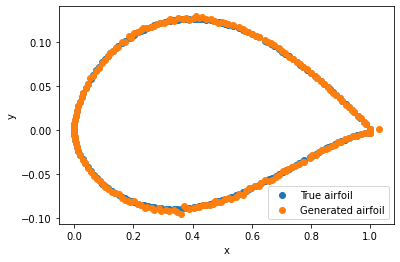

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


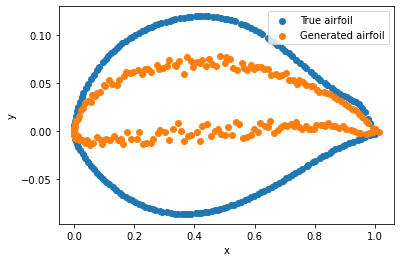

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


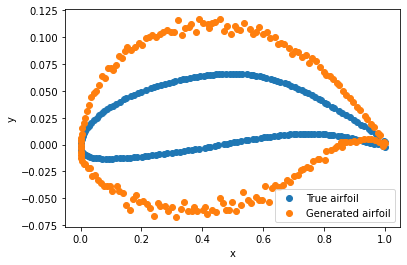

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


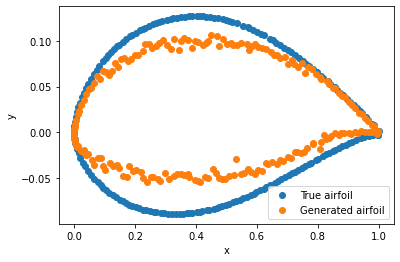

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


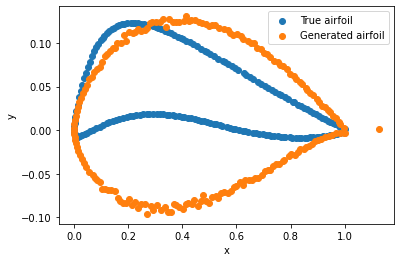

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


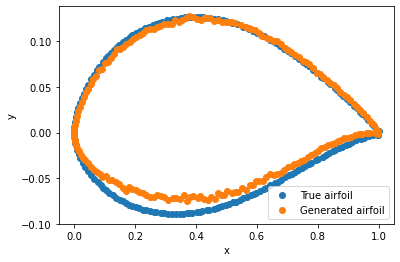

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


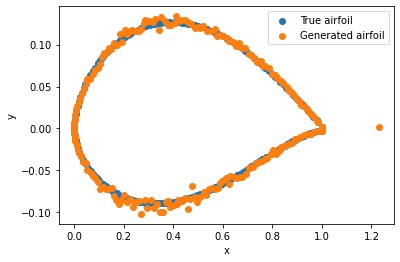

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


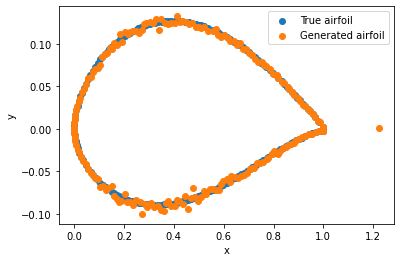

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


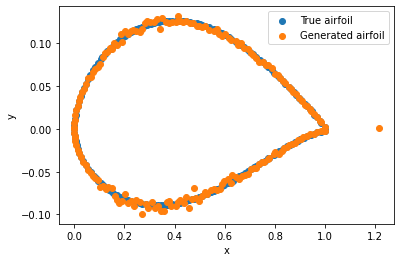

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


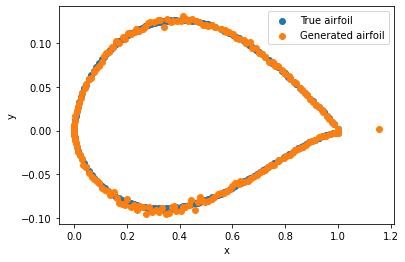

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


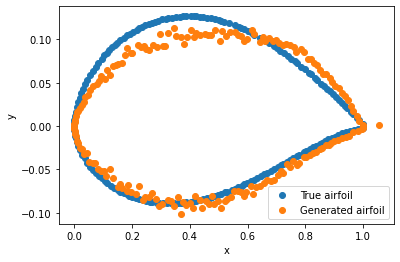

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


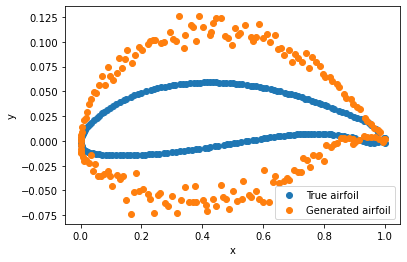

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


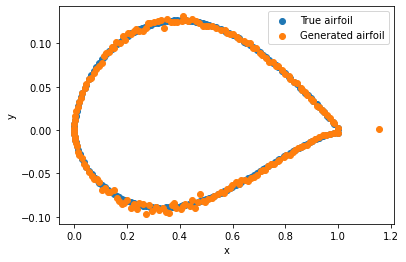

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


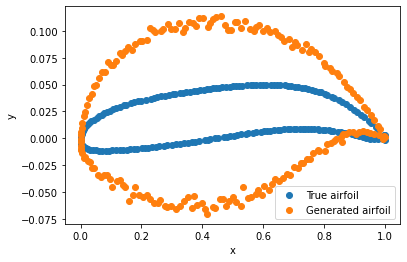

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


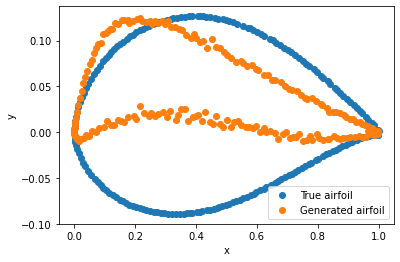

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


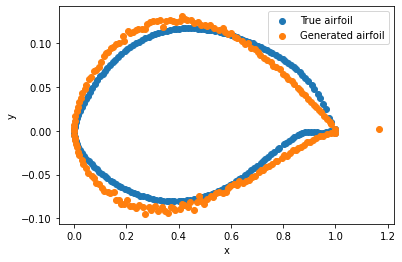

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


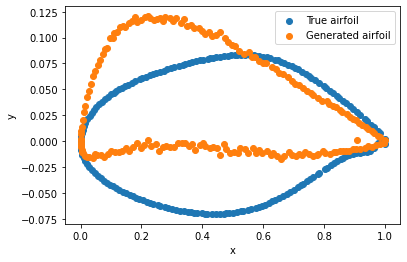

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


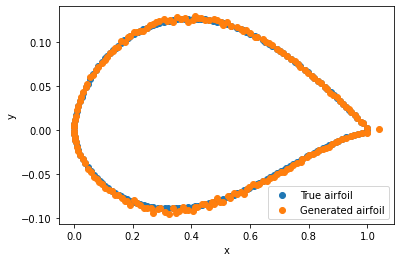

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


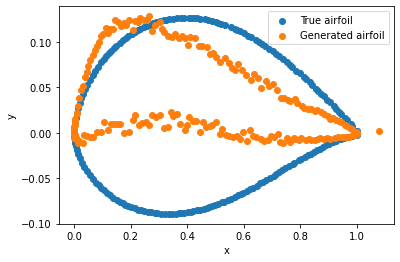

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


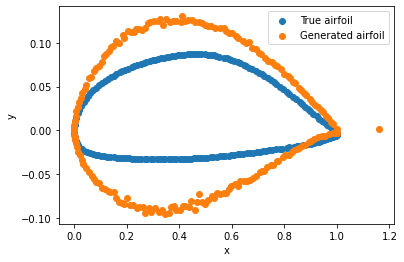

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


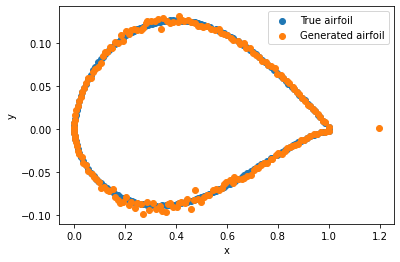

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


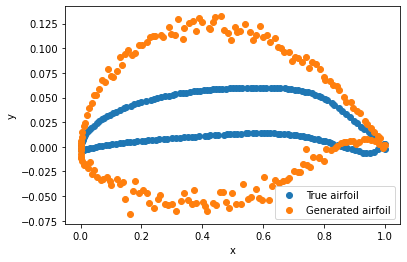

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


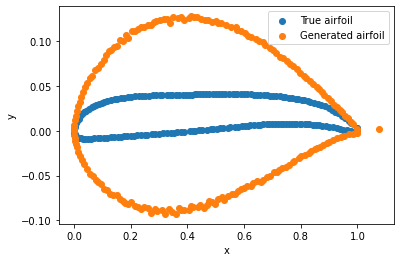

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


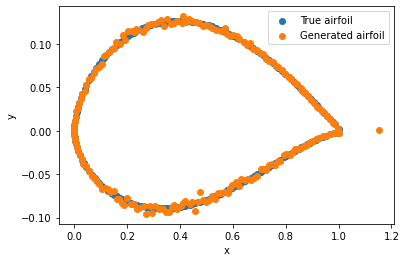

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


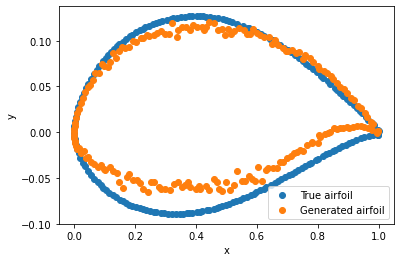

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


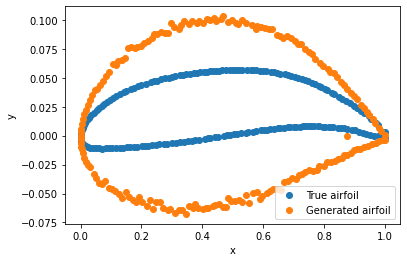

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


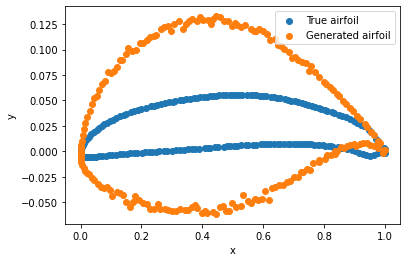

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


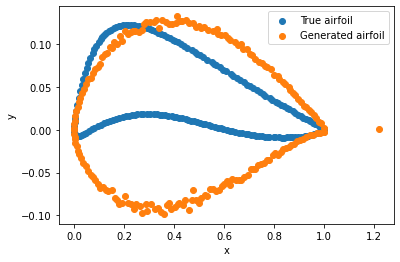

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


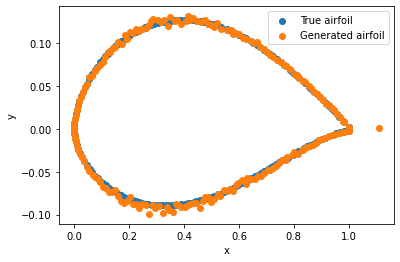

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


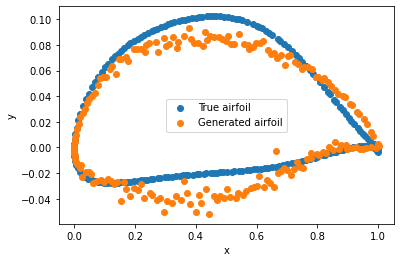

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


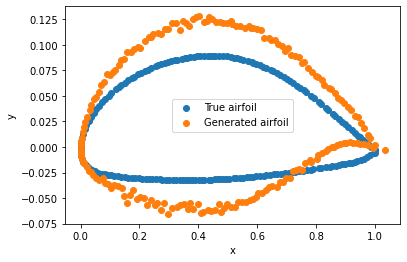

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


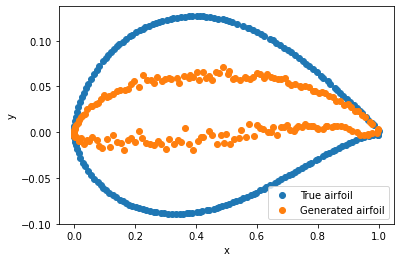

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


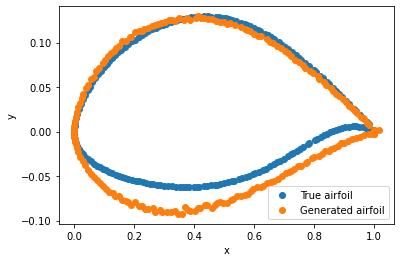

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


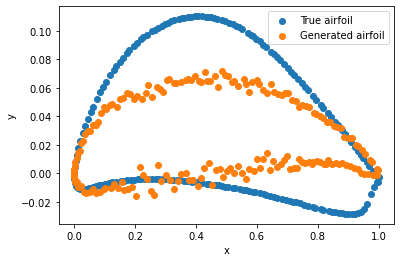

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


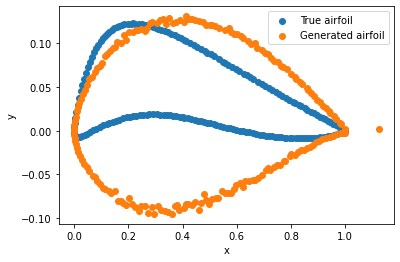

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


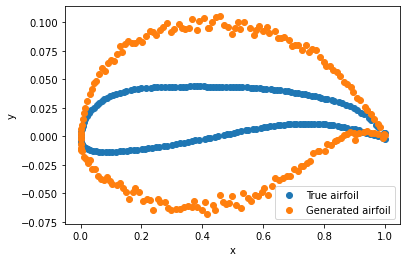

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


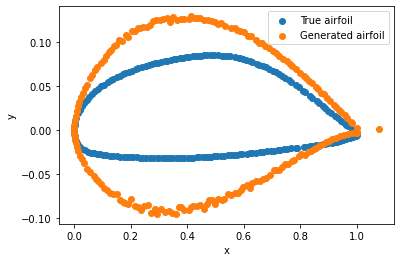

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


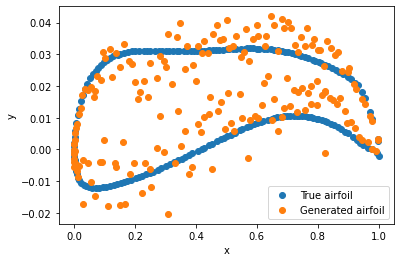

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


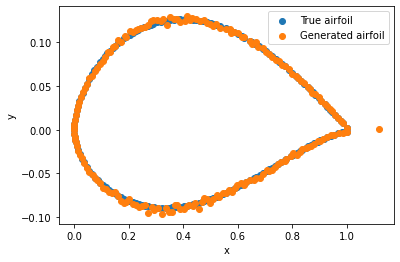

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


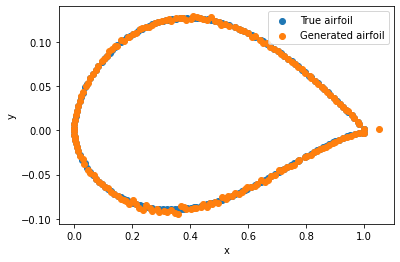

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


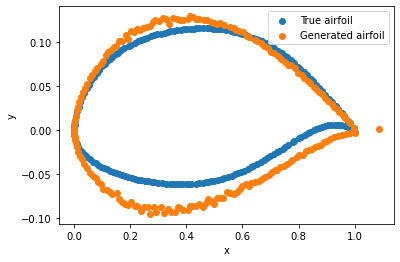

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


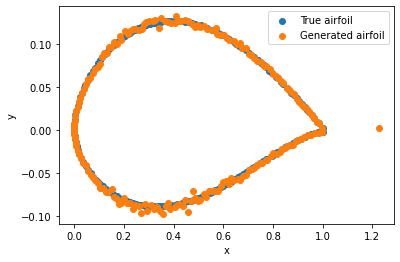

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


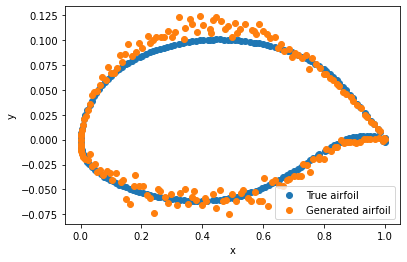

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


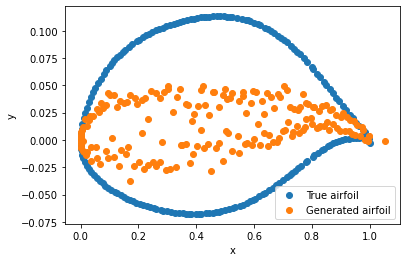

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


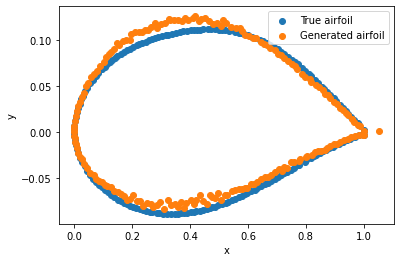

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


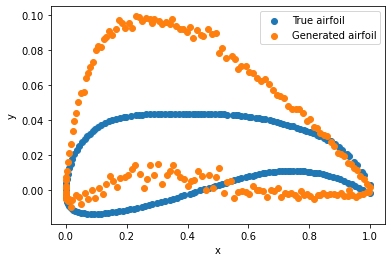

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


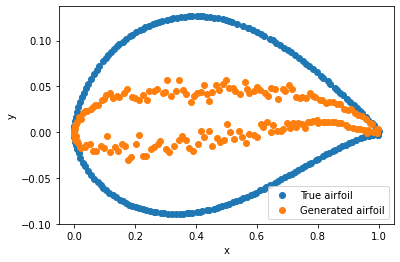

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


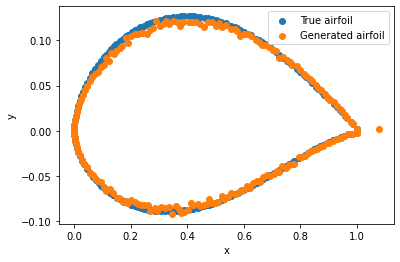

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


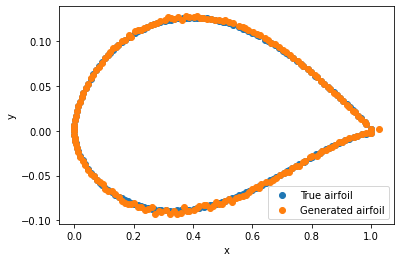

In [53]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = wgan.generator #cond_gan.generator

for i in range(len(x_test)):
    # generate noise
    interpolation_noise = tf.random.normal(shape=(1, noise_dim))
    # concatenate it with a test row
    n_row = i
    input_test=tf.concat([interpolation_noise,np.reshape(x_test[n_row,:],(1,-1))], axis=1)
    # send it to trained_gen
    Y_gen = scaler_y.inverse_transform(trained_gen(input_test))
    Y_gen = np.reshape(Y_gen,(1,-1,2))
    # Reshape the test airfoi
    Y_test_row = Y_test[n_row,:]
    Y_test_row = np.reshape(Y_test_row,(1,-1,2))
    interpolation_noise

    plt.scatter(Y_test_row[:,:,0], Y_test_row[:,:,1],label ='True airfoil')
    plt.scatter(Y_gen[:,:,0], Y_gen[:,:,1],label ='Generated airfoil')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend() 
    plt.savefig('./results/wcgan_airfoil'+str(i)+'.png')
    plt.savefig('./results/wcgan_airfoil'+str(i)+'.eps', format='eps')
    plt.savefig('./results/wcgan_airfoil'+str(i)+'.pdf', format='pdf')
    plt.show()
    


## Predict with the generator and plot the airfoil for cGAN

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


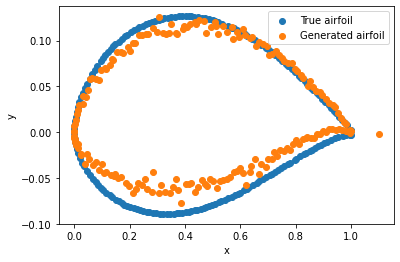

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


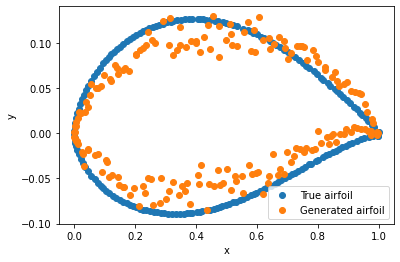

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


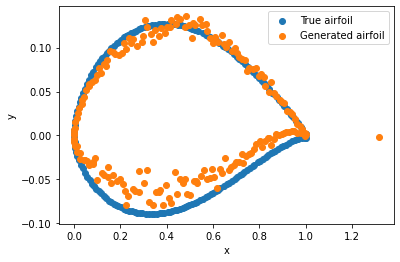

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


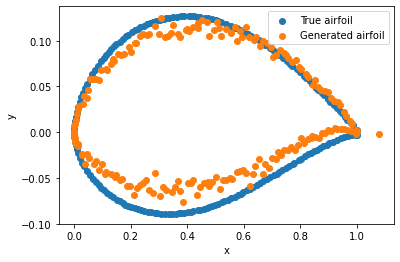

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


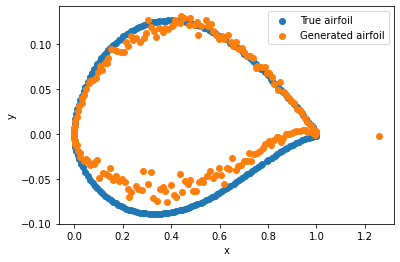

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


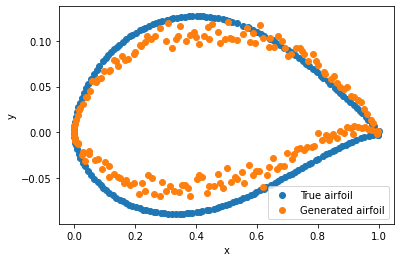

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


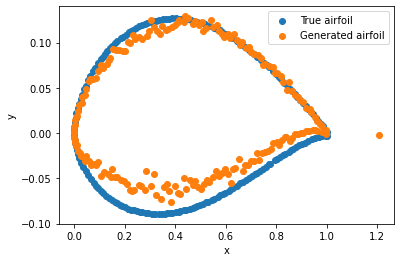

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


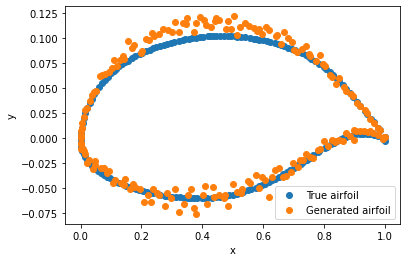

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


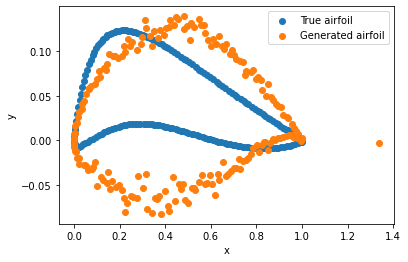

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


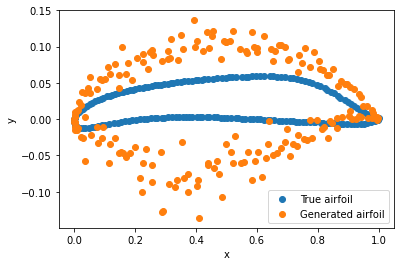

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


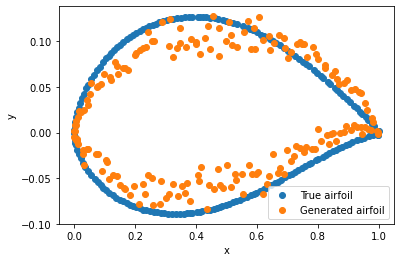

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


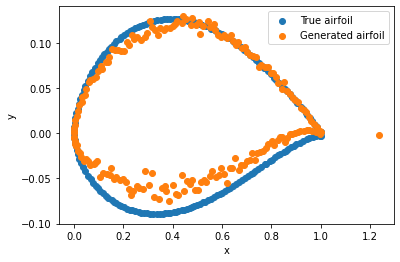

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


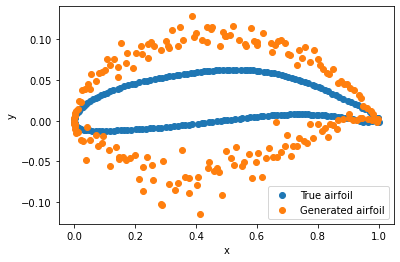

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


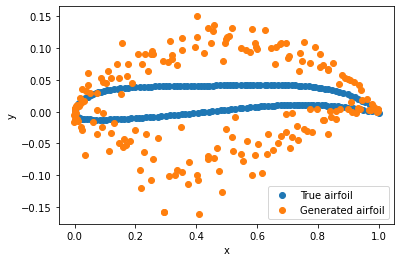

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


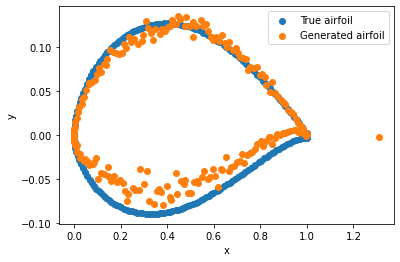

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


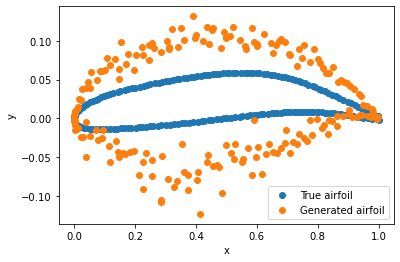

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


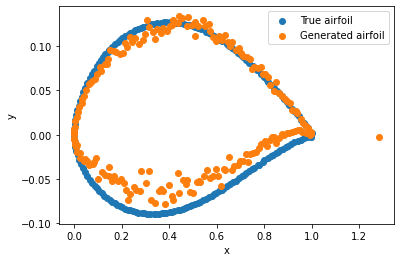

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


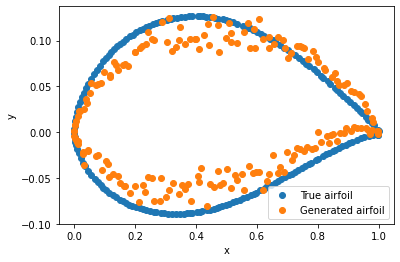

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


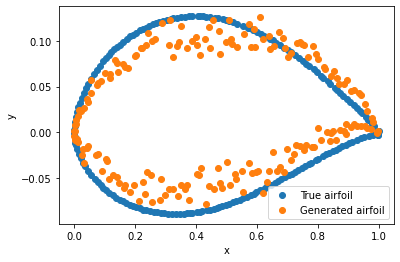

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


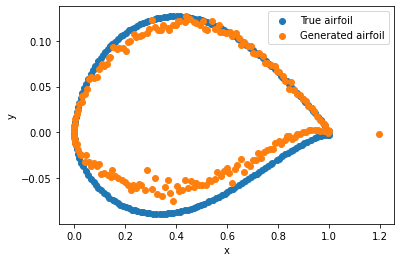

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


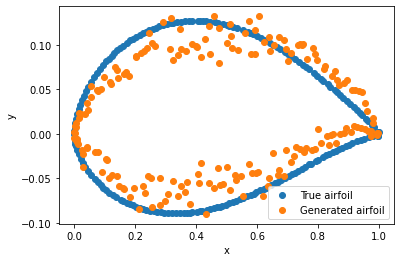

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


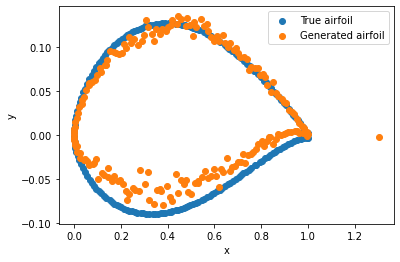

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


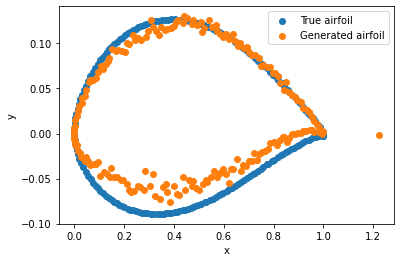

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


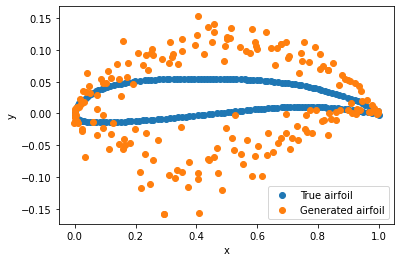

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


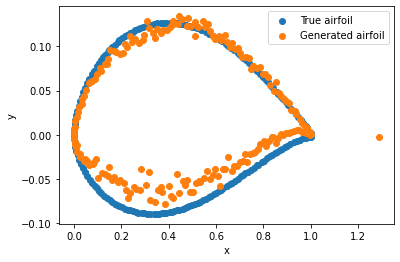

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


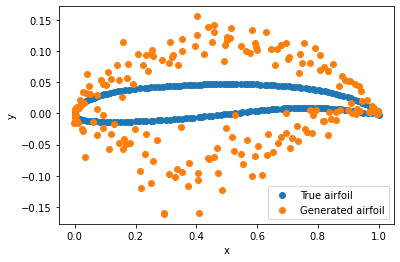

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


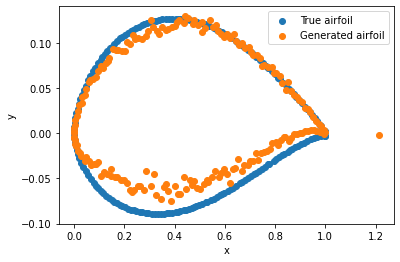

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


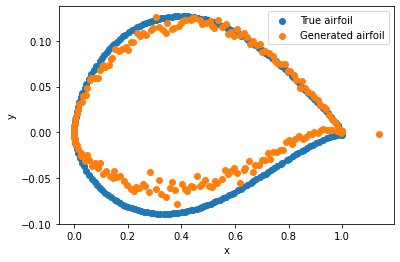

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


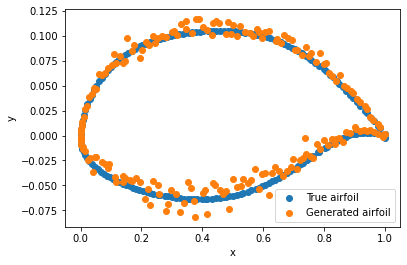

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


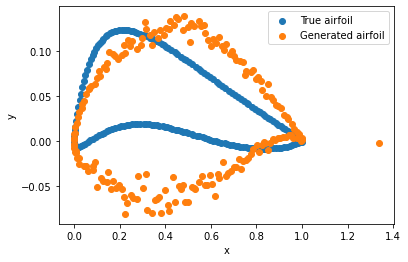

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


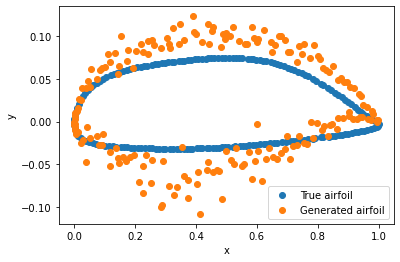

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


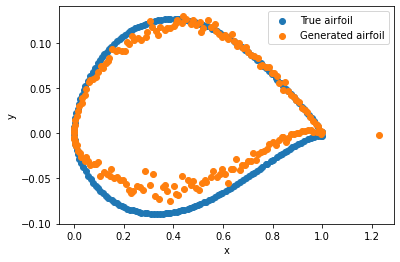

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


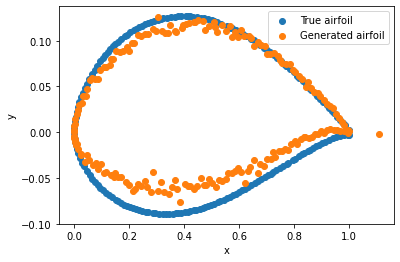

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


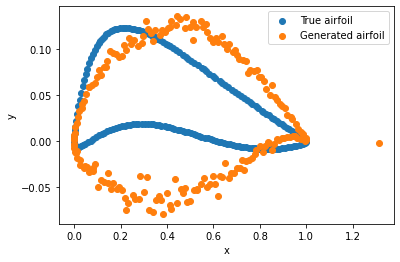

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


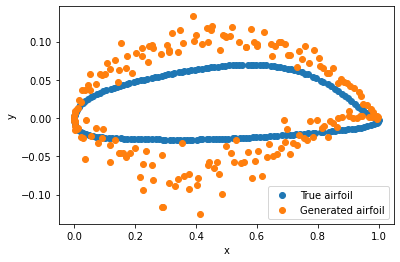

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


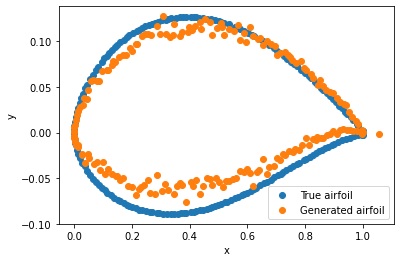

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


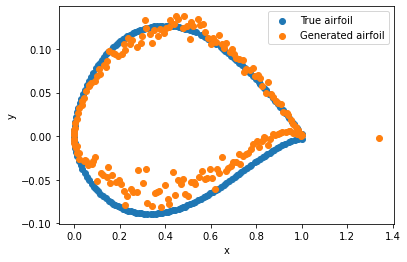

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


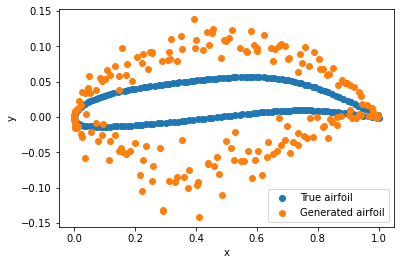

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


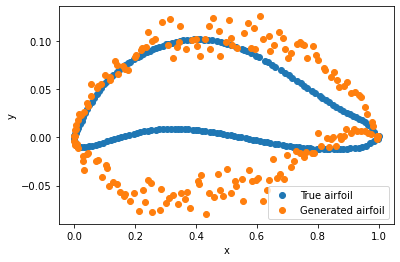

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


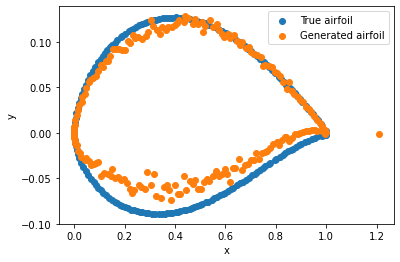

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


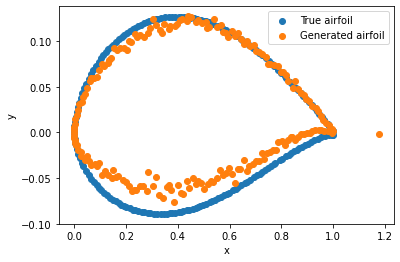

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


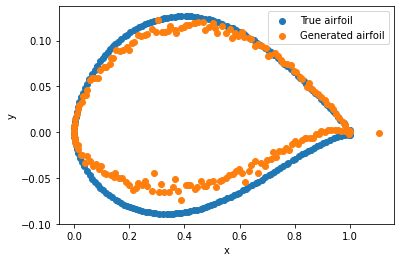

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


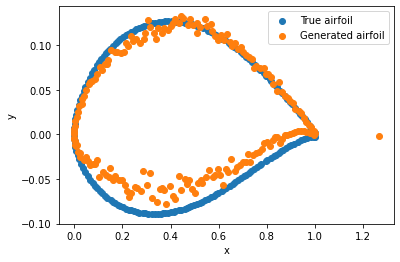

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


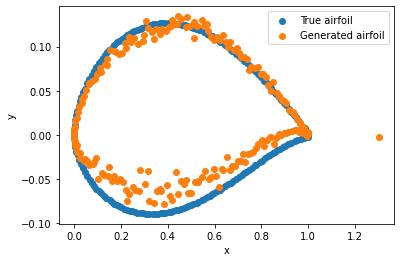

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


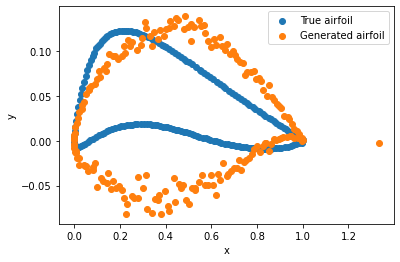

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


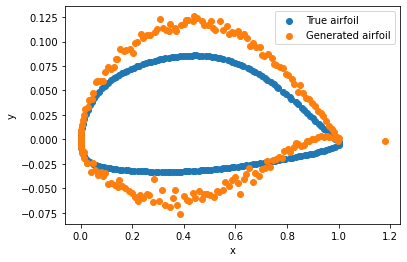

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


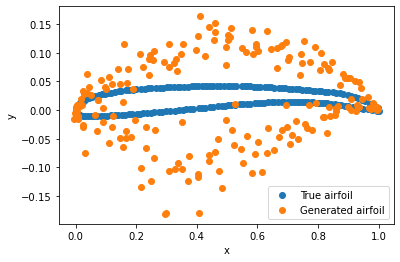

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


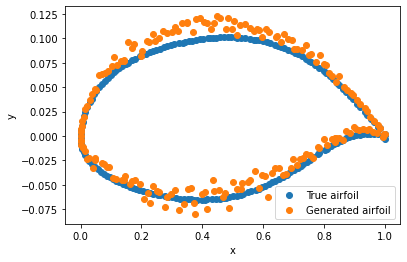

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


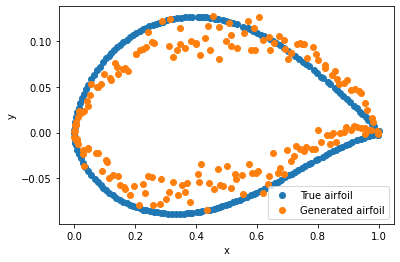

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


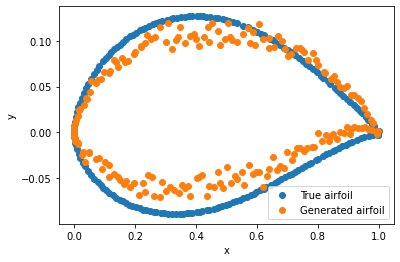

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


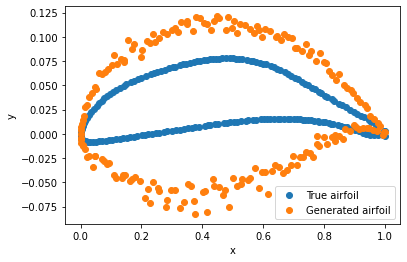

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


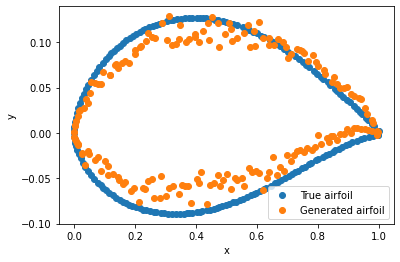

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


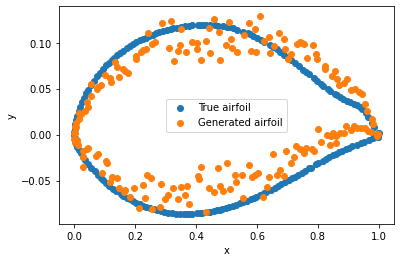

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


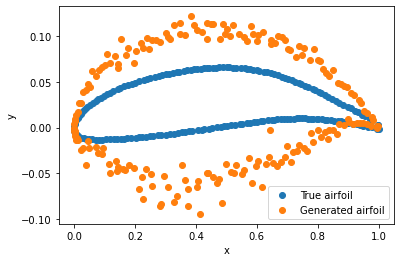

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


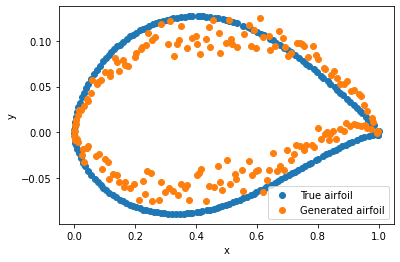

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


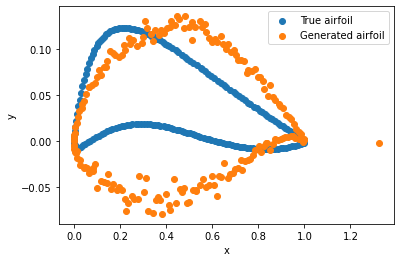

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


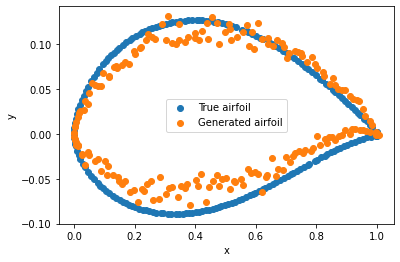

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


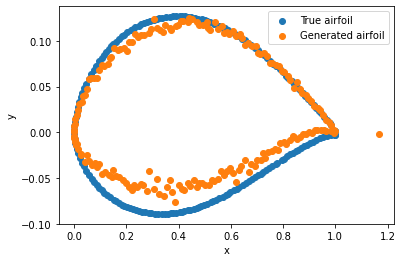

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


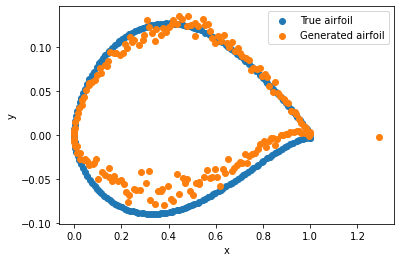

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


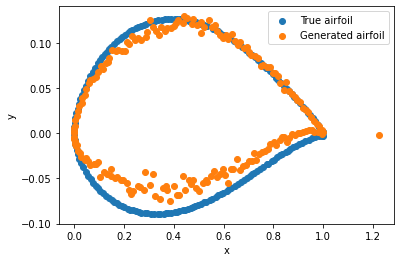

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


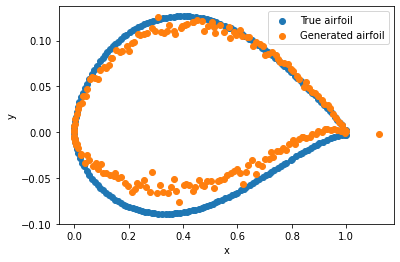

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


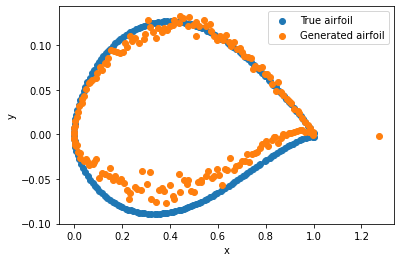

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


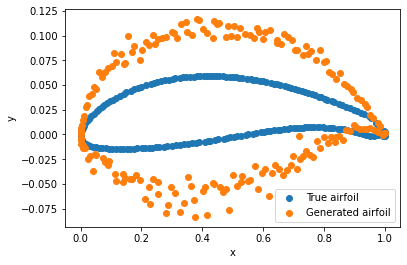

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


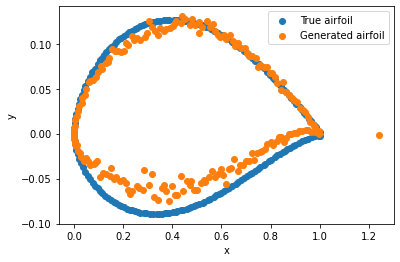

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


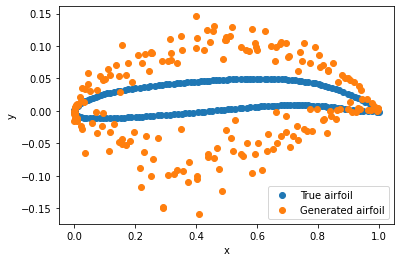

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


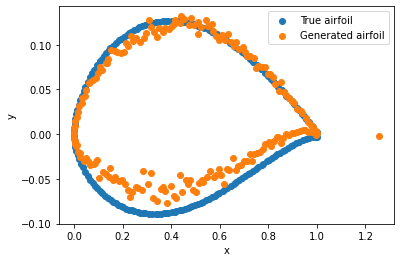

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


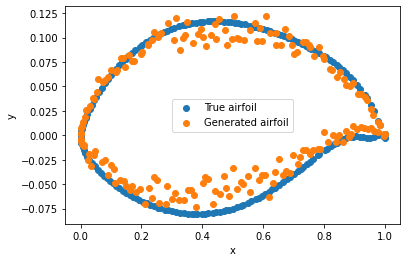

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


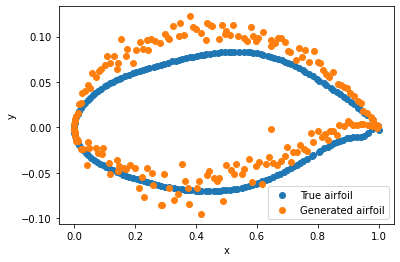

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


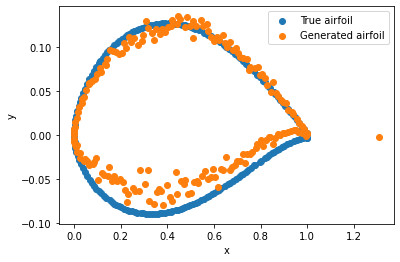

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


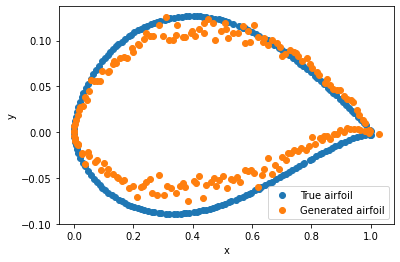

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


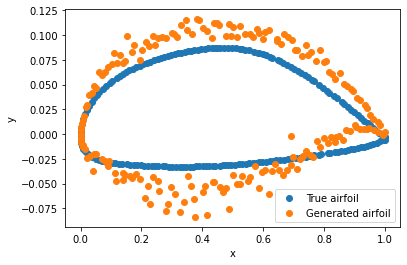

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


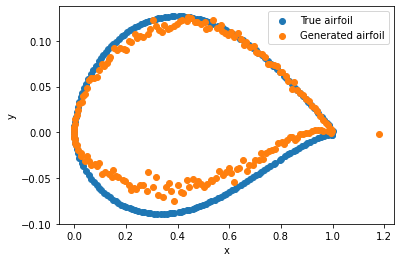

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


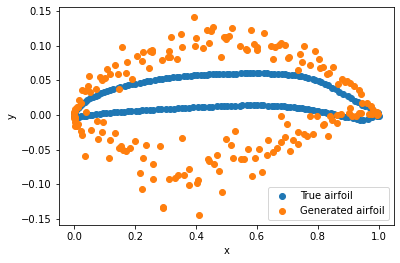

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


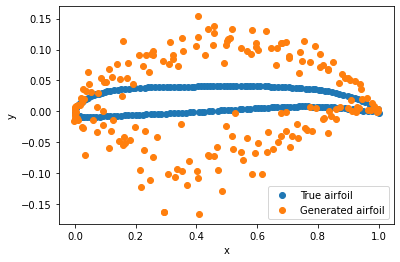

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


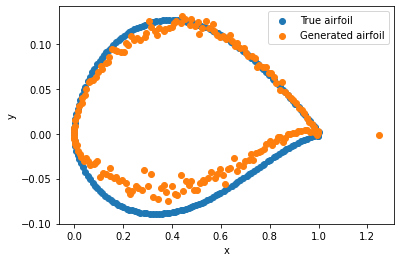

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


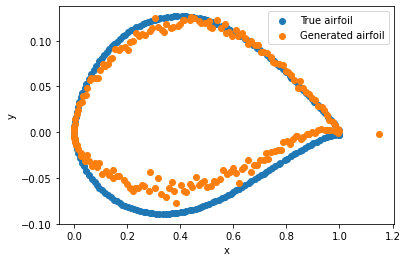

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


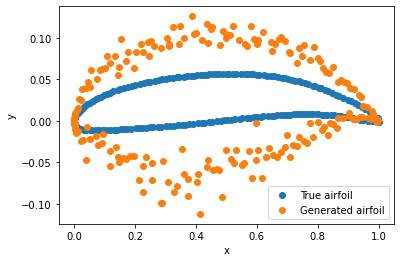

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


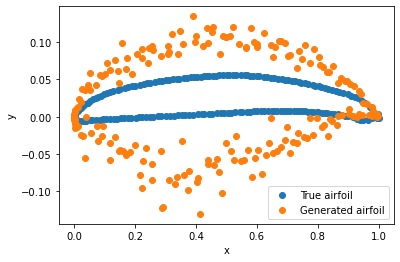

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


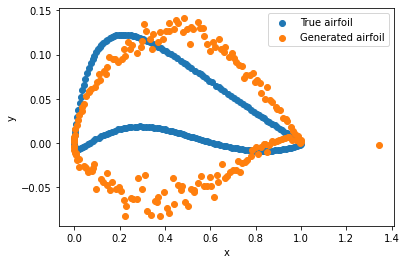

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


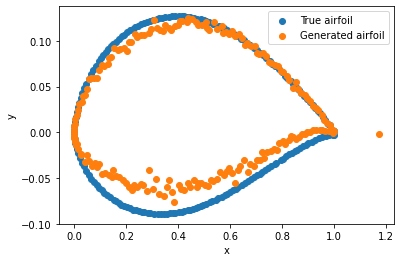

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


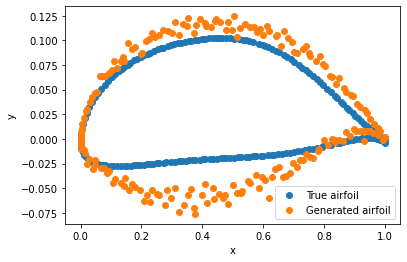

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


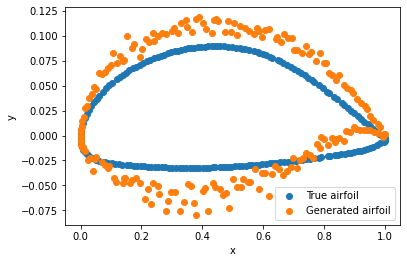

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


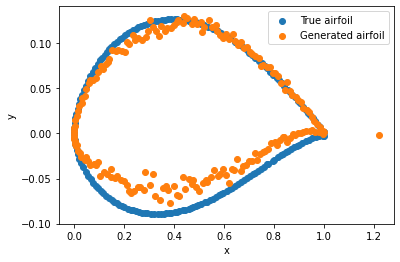

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


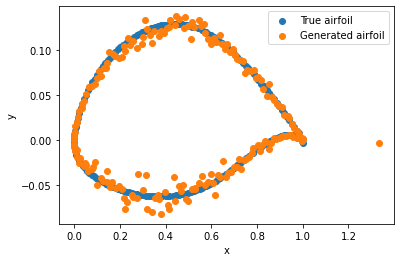

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


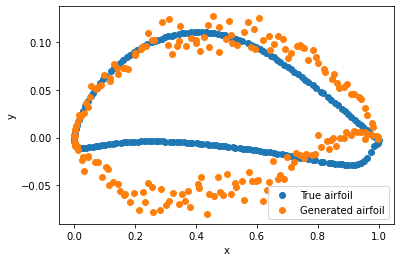

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


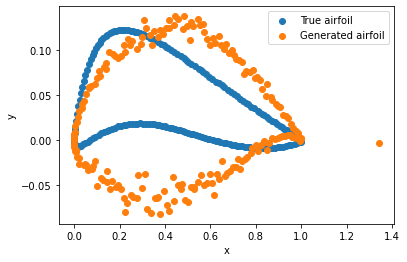

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


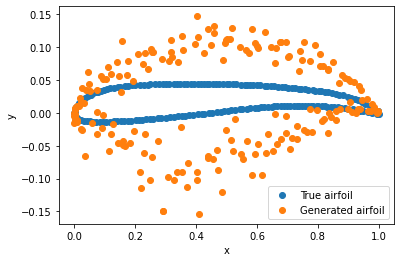

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


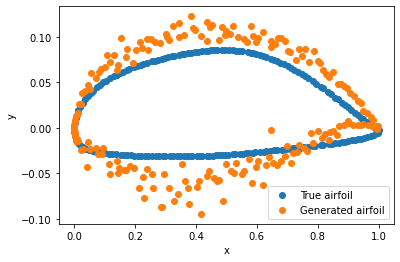

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


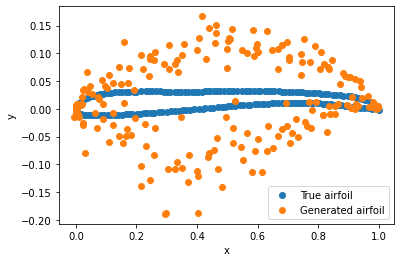

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


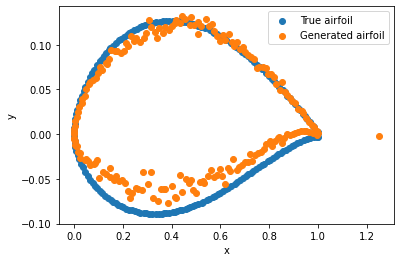

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


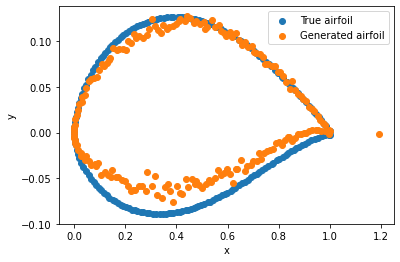

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


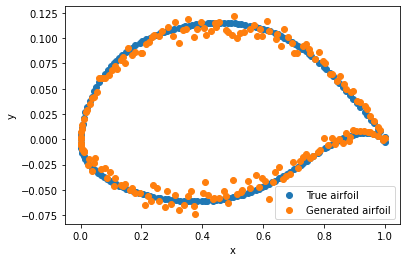

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


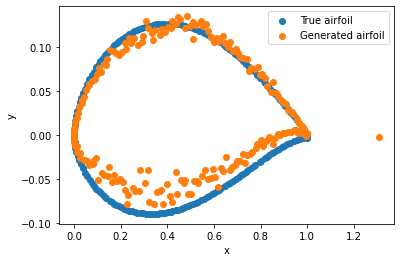

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


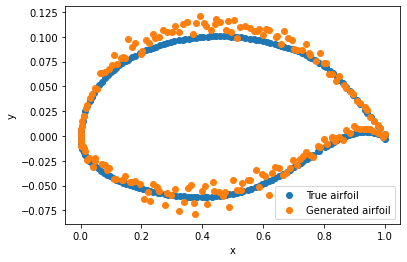

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


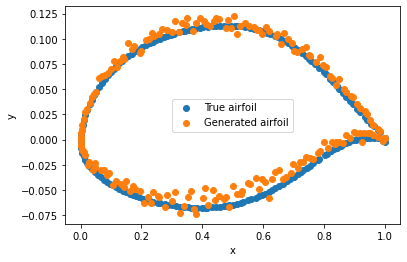

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


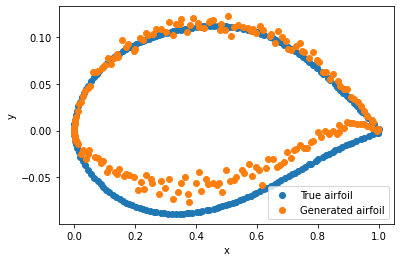

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


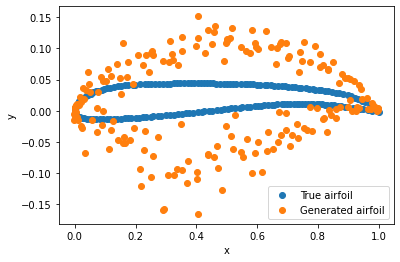

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


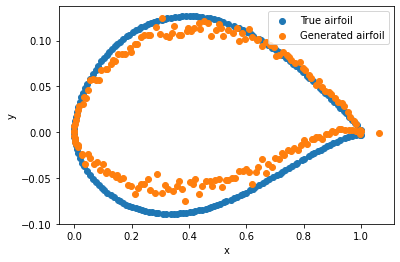

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


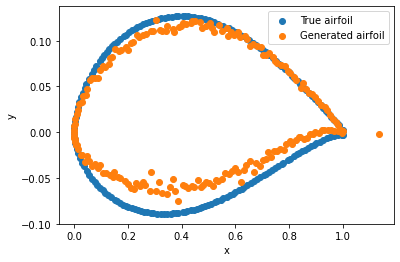

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


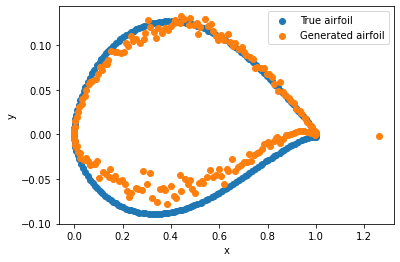

In [54]:
# We first extract the trained generator from our Conditional GAN.
trained_gen = cond_gan.generator #cond_gan.generator

for i in range(len(x_test)):
    # generate noise
    interpolation_noise = tf.random.normal(shape=(1, noise_dim))
    # concatenate it with a test row
    n_row = i
    input_test=tf.concat([interpolation_noise,np.reshape(x_test[n_row,:],(1,-1))], axis=1)
    # send it to trained_gen
    Y_gen = scaler_y.inverse_transform(trained_gen(input_test))
    Y_gen = np.reshape(Y_gen,(1,-1,2))
    # Reshape the test airfoi
    Y_test_row = Y_test[n_row,:]
    Y_test_row = np.reshape(Y_test_row,(1,-1,2))
    interpolation_noise
    
    plt.scatter(Y_test_row[:,:,0], Y_test_row[:,:,1],label ='True airfoil')
    plt.scatter(Y_gen[:,:,0], Y_gen[:,:,1],label ='Generated airfoil')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend() 
    plt.savefig('./results/cgan_airfoil'+str(i)+'.png')
    plt.savefig('./results/cgan_airfoil'+str(i)+'.eps', format='eps')
    plt.savefig('./results/cgan_airfoil'+str(i)+'.pdf', format='pdf')
    plt.show()
    


## Computing the performance of the GANs
We will be using the Mean Relative Living Times (MRLT) and the Geometry Score as described in KHRULKOV, Valentin et OSELEDETS, Ivan. Geometry score: A method for comparing generative adversarial networks. In : International conference on machine learning. PMLR, 2018. p. 2621-2629.
The following code is implemented based on the provided Github: https://github.com/KhrulkovV/geometry-score
For the following import to work, the gs folder from the above github link needs to be placed in your notebook directory.

In [55]:
import gs

## Geometry score cGAN

In [56]:
# Checking cGan
trained_gen = cond_gan.generator #cond_gan.generator
interpolation_noise = tf.random.normal(shape=(len(x_test), noise_dim))
input_test=tf.concat([interpolation_noise,np.reshape(x_test,(len(x_test),-1))], axis=1)
# send it to trained_gen
Y_gen_cgan = scaler_y.inverse_transform(trained_gen(input_test))

In [57]:
rlt_test = gs.rlts(Y_test)

Done 0/1000
Done 10/1000
Done 20/1000
Done 30/1000
Done 40/1000
Done 50/1000
Done 60/1000
Done 70/1000
Done 80/1000
Done 90/1000
Done 100/1000
Done 110/1000
Done 120/1000
Done 130/1000
Done 140/1000
Done 150/1000
Done 160/1000
Done 170/1000
Done 180/1000
Done 190/1000
Done 200/1000
Done 210/1000
Done 220/1000
Done 230/1000
Done 240/1000
Done 250/1000
Done 260/1000
Done 270/1000
Done 280/1000
Done 290/1000
Done 300/1000
Done 310/1000
Done 320/1000
Done 330/1000
Done 340/1000
Done 350/1000
Done 360/1000
Done 370/1000
Done 380/1000
Done 390/1000
Done 400/1000
Done 410/1000
Done 420/1000
Done 430/1000
Done 440/1000
Done 450/1000
Done 460/1000
Done 470/1000
Done 480/1000
Done 490/1000
Done 500/1000
Done 510/1000
Done 520/1000
Done 530/1000
Done 540/1000
Done 550/1000
Done 560/1000
Done 570/1000
Done 580/1000
Done 590/1000
Done 600/1000
Done 610/1000
Done 620/1000
Done 630/1000
Done 640/1000
Done 650/1000
Done 660/1000
Done 670/1000
Done 680/1000
Done 690/1000
Done 700/1000
Done 710/1000
Don

In [58]:
mrlt_test = np.mean(rlt_test, axis=0)

In [59]:
rlt_pred_cgan = gs.rlts(Y_gen_cgan)

Done 0/1000
Done 10/1000
Done 20/1000
Done 30/1000
Done 40/1000
Done 50/1000
Done 60/1000
Done 70/1000
Done 80/1000
Done 90/1000
Done 100/1000
Done 110/1000
Done 120/1000
Done 130/1000
Done 140/1000
Done 150/1000
Done 160/1000
Done 170/1000
Done 180/1000
Done 190/1000
Done 200/1000
Done 210/1000
Done 220/1000
Done 230/1000
Done 240/1000
Done 250/1000
Done 260/1000
Done 270/1000
Done 280/1000
Done 290/1000
Done 300/1000
Done 310/1000
Done 320/1000
Done 330/1000
Done 340/1000
Done 350/1000
Done 360/1000
Done 370/1000
Done 380/1000
Done 390/1000
Done 400/1000
Done 410/1000
Done 420/1000
Done 430/1000
Done 440/1000
Done 450/1000
Done 460/1000
Done 470/1000
Done 480/1000
Done 490/1000
Done 500/1000
Done 510/1000
Done 520/1000
Done 530/1000
Done 540/1000
Done 550/1000
Done 560/1000
Done 570/1000
Done 580/1000
Done 590/1000
Done 600/1000
Done 610/1000
Done 620/1000
Done 630/1000
Done 640/1000
Done 650/1000
Done 660/1000
Done 670/1000
Done 680/1000
Done 690/1000
Done 700/1000
Done 710/1000
Don

In [60]:
mrlt_pred_cgan = np.mean(rlt_pred_cgan, axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


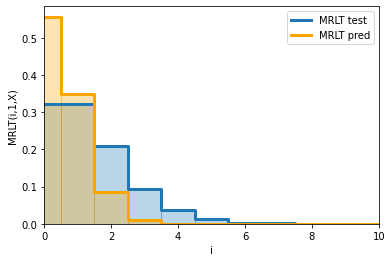

In [61]:
gs.fancy_plot(mrlt_test, label='MRLT test')
gs.fancy_plot(mrlt_pred_cgan, 'orange', label='MRLT pred')
plt.xlim([0, 10])
plt.xlabel('i')
plt.ylabel('MRLT(i,1,X)')
plt.legend()
plt.savefig('./results/mrlt_pred_cgan.png')
plt.savefig('./results/mrlt_pred_cgan.eps', format='eps')
plt.savefig('./results/mrlt_pred_cgan.pdf', format='pdf')

In [62]:
# Compute score
gs.geom_score(rlt_test, rlt_pred_cgan)

0.08031451953842042

## Geometry score WcGAN

In [63]:
# Checking WcGan
trained_gen = wgan.generator #cond_gan.generator
interpolation_noise = tf.random.normal(shape=(len(x_test), noise_dim))
input_test=tf.concat([interpolation_noise,np.reshape(x_test,(len(x_test),-1))], axis=1)
# send it to trained_gen
Y_gen_wcgan = scaler_y.inverse_transform(trained_gen(input_test))

In [ ]:
rlt_test = gs.rlts(Y_test)

Done 0/1000
Done 10/1000
Done 20/1000
Done 30/1000
Done 40/1000
Done 50/1000
Done 60/1000
Done 70/1000
Done 80/1000
Done 90/1000
Done 100/1000
Done 110/1000
Done 120/1000
Done 130/1000
Done 140/1000
Done 150/1000
Done 160/1000
Done 170/1000
Done 180/1000
Done 190/1000
Done 200/1000
Done 210/1000
Done 220/1000
Done 230/1000
Done 240/1000
Done 250/1000
Done 260/1000
Done 270/1000
Done 280/1000
Done 290/1000
Done 300/1000
Done 310/1000
Done 320/1000
Done 330/1000
Done 340/1000
Done 350/1000
Done 360/1000
Done 370/1000
Done 380/1000
Done 390/1000
Done 400/1000
Done 410/1000
Done 420/1000
Done 430/1000
Done 440/1000
Done 450/1000
Done 460/1000
Done 470/1000
Done 480/1000
Done 490/1000
Done 500/1000
Done 510/1000
Done 520/1000
Done 530/1000
Done 540/1000
Done 550/1000
Done 560/1000
Done 570/1000
Done 580/1000
Done 590/1000
Done 600/1000
Done 610/1000
Done 620/1000
Done 630/1000
Done 640/1000
Done 650/1000
Done 660/1000
Done 670/1000
Done 680/1000
Done 690/1000
Done 700/1000
Done 710/1000
Don

In [ ]:
mrlt_test = np.mean(rlt_test, axis=0)

In [ ]:
rlt_pred_wcgan = gs.rlts(Y_gen_wcgan)

In [ ]:
mrlt_pred_wcgan = np.mean(rlt_pred_wcgan, axis=0)

In [ ]:
gs.fancy_plot(mrlt_test, label='MRLT test')
gs.fancy_plot(mrlt_pred_wcgan, 'orange', label='MRLT pred')
plt.xlim([0, 10])
plt.xlabel('i')
plt.ylabel('MRLT(i,1,X)')
plt.legend()
plt.savefig('./results/mrlt_pred_wcgan.png')
plt.savefig('./results/mrlt_pred_wcgan.eps', format='eps')
plt.savefig('./results/mrlt_pred_wcgan.pdf', format='pdf')

In [ ]:
# Compute score
gs.geom_score(rlt_test, rlt_pred_wcgan)

## Plotting all the MRLT on one graph for comparison purposes

In [ ]:
gs.fancy_plot(mrlt_test, label='MRLT test')
gs.fancy_plot(mrlt_pred_cgan, 'orange', label='MRLT cGAN')
gs.fancy_plot(mrlt_pred_wcgan, 'green', label='MRLT WcGAN')
plt.xlabel('i')
plt.ylabel('MRLT(i,1,X)')
plt.xlim([0, 8])
plt.legend()
plt.savefig('./results/mrlt_pred_all.png')
plt.savefig('./results/mrlt_pred_all.eps', format='eps')
plt.savefig('./results/mrlt_pred_all.pdf', format='pdf')